<a href="https://colab.research.google.com/github/diogoruivo47/Data-Mining/blob/main/Final_clustering_Kmeans%26SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex; justify-content: center; align-items: center; padding: 20px;">
    <div style="flex-shrink: 0; display: flex; align-items: center; padding-right: 20px;">
        <img src="https://adnova.novaims.unl.pt/media/22ui3ptm/logo.svg" alt="Nova IMS Logo" style="width: 200px;"/>
    </div>
    <div style="text-align: center;">
        <h1>ABCDEats Inc. - Data Mining Project</h1>
        <h3>Fall Semester 2024-2025</h3>
        <h2>Group 47 Members:</h2>
        <ul style="list-style-type:none; padding: 0;">
            <li>Chiel Groeneveld, 20240662 </li>
            <li>Daan van Holten, 20240681 </li>
            <li>Diogo Ruivo, 20240584 </li>
        </ul>
    </div>
</div>


**Table of Contents** <br>
* [8.Import Libraries](#importlibraries)
* [9.Import Dataset](#importdataset)
* [10.Scaling](#scaling)
    * [10.1 Analysis](#analysis)
* [11.Function Creation](#functions)
* [12.Segmentation](#segmentation)
    * [12.1 Preference-Based Segment](#preference)
    * [12.2 Shopping-Based Segment](#shopping)
    * [12.3 Value-Based Segment](#value)
* [13.Cluster Analysis](#clusteranalysis)
    * [13.1 Centroids](#centroids)
    * [13.2 Profiling](#profiling)
    * [13.3 Merging](#merging)

<hr>
<a class="anchor" id="importlibraries">
    
# 8. Import libraries
    
</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#mathplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colorbar

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#PCA
from sklearn.decomposition import PCA

#Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier

#Clustering Scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

#SOM
from minisom import MiniSom
from matplotlib import colors as mpl_colors
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colorbar import Colorbar

#TSNE
from sklearn.manifold import TSNE

from sklearn.model_selection import ParameterSampler

from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [2]:
# need to install optuna
# !pip install optuna

<hr>
<a class="anchor" id="importdataset">
    
# 9. Import Dataset
    
</a>

In [3]:
df = pd.read_csv('data_clean2.csv')

In [4]:
pd.set_option('display.max_columns', None)
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df_copy = df.copy()
categorical_cols = ['last_promo', 'payment_method', 'customer_region_0', 'customer_region_1', 'customer_region_2', 'customer_region_3']
cat_df = df_copy[categorical_cols].copy()
numerical_cols = df_copy.columns.difference(categorical_cols)
num_df = df_copy[numerical_cols].copy()

<hr>
<a class="anchor" id="scaling">
    
# 10. Scaling
    
</a>

In [6]:
def scale_features(df: pd.DataFrame) -> pd.DataFrame:
    # Copy DataFrame to avoid modifying the original
    df = df.copy()

    # Convert 'category' columns to float64
    for column in df.columns:
        if df[column].dtype.name == 'category':
            df[column] = df[column].astype('float64')

    # Initialize the scaled DataFrame
    scaled_df = pd.DataFrame(index=df.index)

    # 1. Binary features
    binary_cols = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                   'CLV_Score', 'RFM_Score', 'Loyalty']
    for col in binary_cols:
        scaled_df[col] = df[col]

    # 2. CUI features
    cui_cols = [col for col in df.columns if col.startswith('CUI_')]
    for col in cui_cols:
        nonzero_mask = df[col] != 0
        scaled = np.zeros(len(df))
        if nonzero_mask.any():
            nonzero_values = df.loc[nonzero_mask, col].values.reshape(-1, 1)
            scaled[nonzero_mask] = StandardScaler().fit_transform(nonzero_values).ravel()
        scaled_df[col] = scaled

    # 2.1 Cuisine groups
    cuisine_cols = ['Other_Asian', 'General_Asian', 'Western', 
                    'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes']

    for col in cuisine_cols:
        # Logarithmic transformation
        log_transformed = np.log1p(df[col])

        # MinMaxScaler transformation
        scaled_df[col] = MinMaxScaler().fit_transform(log_transformed.values.reshape(-1, 1)).ravel()

    # 3. Ordinal features
    ordinal_cols = ['is_chain', 'Orders_Night', 'Orders_Dawn', 
                    'Orders_Morning', 'Orders_Afternoon', 
                    'Orders_Evening', 'Orders_Dusk', 'Age_Group', 'Weekend', 'Weekday']
    for col in ordinal_cols:
        values = df[col].values.reshape(-1, 1)
        scaled_df[col] = MinMaxScaler().fit_transform(values).ravel()

    # 4. Continuous features
    continuous_cols = ['vendor_count', 'product_count', 'Total_Orders_Per_Client',
                       'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn',
                       'activity']

    for col in continuous_cols:
        values = df[col].values
        if np.std(values) == 0:
            # If the column has zero variance, copy as is
            scaled_df[col] = values
            continue

        # Handling skewness
        if pd.Series(values, dtype='float64').skew() > 1:
            min_val = values.min()
            if min_val < 0:
                values = values - min_val + 1e-10
            values = np.log1p(values)

        # StandardScaler transformation
        scaled_df[col] = StandardScaler().fit_transform(values.reshape(-1, 1)).ravel()

    # Final Validation
    missing_cols = set(df.columns) - set(scaled_df.columns)
    if missing_cols:
        raise ValueError(f"Violation of conservation of features: Missing columns: {missing_cols}")

    return scaled_df

# Execution
num_df = scale_features(num_df)

# Validation
print("\nFeature Verification:")
print(f"Input shape: {df.shape}")
print(f"Output shape: {num_df.shape}")
print("\nFeature Conservation Check:")
print("All features preserved:", set(df.columns) == set(num_df.columns))


Feature Verification:
Input shape: (31737, 56)
Output shape: (31737, 50)

Feature Conservation Check:
All features preserved: False


<hr>
<a class="anchor" id="analysis">
    
## 10.1 Analysis
    
</a>

In [7]:
num_df.describe()

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,CLV_Score,RFM_Score,Loyalty,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,Other_Asian,General_Asian,Western,Beverages_Cafe,Desserts_Snacks,Main_Dishes,is_chain,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,Age_Group,Weekend,Weekday,vendor_count,product_count,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04
mean,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471,0.066017,0.065291,0.161565,1.432862e-17,-2.149293e-17,7.500136e-18,2.910501e-18,8.955386e-19,3.358270e-18,-1.119423e-18,2.238847e-18,-3.134385e-18,-1.791077e-18,2.955277e-17,-4.477693e-19,1.432862e-17,-7.612078e-18,-4.477693e-18,0.156612,0.159767,0.189800,0.085866,0.083832,0.130248,0.375482,0.014261,0.015778,0.018593,0.024953,0.027269,0.007183,0.354350,0.047009,0.040330,-2.865724e-16,1.432862e-16,8.597171e-17,3.725441e-16,1.862720e-16,-5.415770e-16,-2.865724e-17,-5.731447e-17,-2.865724e-17
std,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202,0.040343,0.037089,0.228829,5.831157e-01,6.122438e-01,4.136793e-01,2.074671e-01,3.199130e-01,3.331337e-01,2.520398e-01,2.614290e-01,3.296154e-01,4.507507e-01,4.455477e-01,2.648418e-01,4.710219e-01,3.656887e-01,2.737347e-01,0.196445,0.221996,0.225974,0.179631,0.190431,0.204336,0.325380,0.045378,0.045065,0.036090,0.043672,0.047679,0.023012,0.158256,0.064726,0.051447,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011496,0.012048,0.000000,-8.624023e-01,-8.129453e-01,-8.003939e-01,-7.191284e-01,-8.038850e-01,-5.848230e-01,-8.514873e-01,-7.593775e-01,-8.314770e-01,-7.621574e-01,-7.985325e-01,-6.980246e-01,-7.789587e-01,-8.852547e-01,-8.938746e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.177017e+00,-1.437495e+00,-1.028486e+00,-3.453503e+00,-1.522614e+00,-8.502307e-01,-9.278250e-01,-1.174464e+00,-1.205454e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030806,0.031640,0.000000,0.000000e+00,-5.531087e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.013333,-1.177017e+00,-7.825958e-01,-6.457117e-01,-6.840819e-01,-7.672763e-01,-8.502307e-01,-7.265809e-01,-8.257126e-01,-1.103443e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055885,0.056626,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.400000,0.034483,0.026667,-3.174828e-01,-3.179376e-01,-2.629377e-01,1.415649e-02,-2.610392e-01,-2.909657e-01,-5.260947e-01,

In [8]:
# Calculate the Spearman correlation matrix
spearman_corr = num_df.corr(method='spearman')

# Display the correlation matrix
spearman_corr

,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,CLV_Score,RFM_Score,Loyalty,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,Other_Asian,General_Asian,Western,Beverages_Cafe,Desserts_Snacks,Main_Dishes,is_chain,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,Age_Group,Weekend,Weekday,vendor_count,product_count,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity
DOW_0,1.000000,0.239451,0.234692,0.225882,0.176707,0.130844,0.144047,0.041674,0.015459,0.309971,-0.007948,0.031864,-0.023641,-0.009666,0.003849,-0.012840,-0.020678,-0.009510,-0.021093,0.006957,-0.032283,-0.020294,0.014130,-0.016510,-0.011773,0.217530,0.162734,0.161407,0.167142,0.101350,0.213297,0.380964,0.117614,0.112148,0.289692,0.270555,0.209825,0.166647,0.014155,0.149966,0.550793,0.444394,0.467621,0.487078,0.367186,-0.095872,0.090421,-0.078086,-0.241139,0.398360
DOW_1,0.239451,1.000000,0.248535,0.235444,0.185994,0.122919,0.123414,0.052926,0.025526,0.320087,0.004187,0.017901,-0.018165,-0.005425,0.006780,-0.014745,-0.013502,-0.016770,-0.022564,0.007983,-0.029118,-0.014173,0.022086,-0.017793,-0.010852,0.225043,0.157037,0.163708,0.163114,0.090826,0.220132,0.381061,0.092907,0.101717,0.271741,0.274315,0.222328,0.172557,0.002188,0.129364,0.563406,0.441420,0.467889,0.488111,0.361109,-0.106459,0.090598,-0.072986,-0.251493,0.397150
DOW_2,0.234692,0.248535,1.000000,0.242585,0.197536,0.120607,0.135044,0.063361,0.036966,0.336971,-0.002909,0.008809,-0.019424,-0.005220,0.007988,-0.007617,-0.030035,-0.022447,-0.012624,0.014201,-0.019137,-0.030887,0.029338,-0.013291,-0.016498,0.217496,0.156814,0.170590,0.155856,0.096844,0.226704,0.384234,0.089564,0.097099,0.286622,0.278179,0.238674,0.163488,0.002543,0.135598,0.578590,0.449241,0.486109,0.505805,0.377148,-0.101740,0.099674,-0.087117,-0.273226,0.417149
DOW_3,0.225882,0.235444,0.242585,1.000000,0.204534,0.131171,0.128172,0.094587,0.066596,0.339671,-0.000416,0.021530,-0.016312,-0.010115,-0.000787,-0.000660,-0.025462,-0.029278,-0.014567,-0.000934,-0.026389,-0.014357,0.008195,-0.008626,-0.015371,0.230152,0.138672,0.189924,0.157268,0.081022,0.228574,0.382928,0.078979,0.087339,0.273337,0.290232,0.260003,0.160200,0.008337,0.136537,0.584564,0.450414,0.485919,0.506955,0.372713,-0.113150,0.095464,-0.088083,-0.299676,0.421766
DOW_4,0.176707,0.185994,0.197536,0.204534,1.000000,0.139216,0.126009,0.100607,0.055575,0.334988,-0.005596,0.018773,-0.014867,-0.003749,-0.004226,-0.006766,-0.014771,-0.009122,-0.013820,-0.003563,-0.015573,-0.009558,0.020205,-0.007211,-0.007092,0.220503,0.104094,0.234119,0.144282,0.056722,0.215445,0.364731,0.051334,0.053484,0.248499,0.274976,0.296619,0.166407,-0.002040,0.142544,0.559135,0.429584,0.470255,0.489599,0.359802,-0.107482,0.095874,-0.091739,-0.302244,0.404916
DOW_5,0.130844,0.122919,0.120607,0.131171,0.139216,1.000000,0.190266,0.016857,-0.007242,0.271503,-0.008867,0.019214,-0.036072,-0.011699,-0.001307,-0.020450,-0.026734,-0.011719,-0.006826,-0.002263,-0.011149,-0.019269,0.018507,-0.022651,-0.011761,0.201754,0.112397,0.205286,0.138234,0.076364,0.184960,0.335270,0.072311,0.079144,0.224566,0.261760,0.264613,0.169846,-0.002210,0.735104,0.137463,0.409335,0.427865,0.441399,0.328541,-0.091810,0.099923,-0.076712,-0.206894,0.356761
DOW_6,0.144047,0.123414,0.135044,0.128172,0.126009,0.190266,1.000000,-0.004533,-0.029825,0.284548,-0.016091,0.008614,-0.028407,-0.015837,-0.004361,-0.014939,-0.022278,-0.023250,-0.016172,-0.005741,-0.019905,-0.018516,0.016055,-0.013440,-0.012242,0.214797,0.118334,0.207503,0.137562,0.075624,0.178758,0.347896,0.057427,0.069818,0.238807,0.300375,0.267745,0.163296,0.003904,0.759121,0.139561,0.417778,0.445346,0.457593,0.332949,-0.102645,0.110594,-0.103022,-0.220279,0.386163
CLV_Score,0.041674,0.052926,0.063361,0.094587,0.100607,0.016857,-0.004533,1.000000,0.989184,-0.019965,0.109149,0.082841,0.078898,0.

In [9]:
# Get correlations above 0.5 (excluding self-correlations)
strong_corrs = [(i, j, spearman_corr.loc[i, j])
                for i in spearman_corr.index
                for j in spearman_corr.columns
                if abs(spearman_corr.loc[i, j]) > 0.7 and i < j]

# Print sorted results
print("Correlations above 0.5:")
for var1, var2, corr in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} - {var2}: {corr:.3f}")

Correlations above 0.5:
CLV_Score - RFM_Score: 0.989
Total_Orders_Per_Client - product_count: 0.947
Total_Orders_Per_Client - vendor_count: 0.886
Total_Orders_Per_Client - Weekday: 0.847
product_count - vendor_count: 0.842
Total_Orders_Per_Client - activity: 0.832
Weekday - product_count: 0.802
mnt - product_count: 0.795
activity - product_count: 0.784
DOW_6 - Weekend: 0.759
activity - vendor_count: 0.756
Weekday - vendor_count: 0.749
DOW_5 - Weekend: 0.735
Total_Orders_Per_Client - is_chain: 0.727
activity - frq: -0.718
is_chain - vendor_count: 0.705


In [10]:
num_df.columns

Index(['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'CLV_Score', 'RFM_Score', 'Loyalty', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_OTHER',
       'CUI_Street_Food/Snacks', 'CUI_Thai', 'Other_Asian', 'General_Asian',
       'Western', 'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes',
       'is_chain', 'Orders_Night', 'Orders_Dawn', 'Orders_Morning',
       'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk', 'Age_Group',
       'Weekend', 'Weekday', 'vendor_count', 'product_count',
       'Total_Orders_Per_Client', 'mnt', 'mnt_Per_Order', 'Items_Per_Order',
       'frq', 'rcn', 'activity'],
      dtype='object')

<hr>
<a class="anchor" id="functions">
    
# 11. Functions
    
</a>

#### PCA

In [11]:
def pca(df_pca):
    # Initialize PCA
    pca = PCA()
    pca_feat = pca.fit_transform(df_pca)

    # Calculate cumulative explained variance
    explained_variance = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # Find the number of components needed to reach 80% variance
    num_components = np.argmax(cumulative_explained_variance_ratio >= 0.8) + 1

    # Add PCA components explaining 80% variance back to DataFrame
    selected_pcas = pca_feat[:, :num_components]
    for i in range(num_components):
        df_pca[f'PCA_{i+1}'] = selected_pcas[:, i]

    # Plotting
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

    # Plot 1: Scree Plot (Eigenvalues)
    ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 'ro-', linewidth=2, markersize=8, label='Eigenvalues')
    ax1.set_title("Scree Plot (Eigenvalues)", fontsize=18, pad=15, fontweight='bold')
    ax1.set_xlabel("Principal Components", fontsize=14)
    ax1.set_ylabel("Eigenvalue", fontsize=14)
    ax1.set_xticks(range(1, len(explained_variance) + 1, 2))
    ax1.set_xticklabels(range(1, len(explained_variance) + 1, 2), fontsize=12)
    ax1.set_facecolor('white')
    ax1.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax1.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility
    ax1.legend(fontsize=12, loc='upper right')

    # Plot 2: Explained Variance as a Bar Chart
    ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
            color='#1f77b4', alpha=0.7, label='Explained Variance (%)', width=0.8)  # Customize bar color
    ax2.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, 
             'ro-', linewidth=2, markersize=8, label='Cumulative Variance (%)')

    # Customize the plot
    ax2.set_title("Variance Explained by Principal Components", fontsize=18, pad=15, fontweight='bold')
    ax2.set_xlabel("Principal Components", fontsize=14)
    ax2.set_ylabel("Variance (%)", fontsize=14)
    ax2.set_xticks(range(1, len(explained_variance_ratio) + 1, 2))  # Show every 2nd PC for clarity
    ax2.set_xticklabels(range(1, len(explained_variance_ratio) + 1, 2), fontsize=12)
    ax2.set_facecolor('white')
    ax2.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax2.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility

    # Add legend
    ax2.legend(fontsize=12, loc='upper left')

    # Adjust layout to ensure everything fits and has proper padding
    plt.tight_layout(pad=4.0)

    # Show plot
    plt.show()

    return df_pca

In [12]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

#### Feature Selection

In [13]:
def analyze_feature_importance(df):
   # Get cluster labels
   kmeans = KMeans(n_clusters=3, random_state=42)
   labels = kmeans.fit_predict(df)

   # Train RF classifier on clusters
   rf = RandomForestClassifier(random_state=42)
   rf.fit(df, labels)

   # Get feature importance
   importance = pd.DataFrame({
       'feature': df.columns,
       'importance': rf.feature_importances_
   }).sort_values('importance', ascending=False)

   return importance

### Clustering

#### KMeans

In [14]:
def clustering_kmeans(df, k_range=(3, 11), random_state=42):

    # Ensure input is a NumPy array
    np_array = df.values if isinstance(df, pd.DataFrame) else df

    # Clustering metrics
    metrics = []
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)
        labels = kmeans.fit_predict(np_array)

        # Calculate SSE
        sse = np.sum((np_array - kmeans.cluster_centers_[labels]) ** 2)

        # Calculate R2
        r2 = r2_score(np_array, kmeans.cluster_centers_[labels])

        metrics.append({
            'k': k,
            'silhouette': silhouette_score(np_array, labels),
            'calinski': calinski_harabasz_score(np_array, labels),
            'davies': davies_bouldin_score(np_array, labels),
            'inertia': kmeans.inertia_,
            'sse': sse,
            'r2': r2
        })

    # Print metrics
    for m in metrics:
        print(f"\nk={m['k']}:")
        print(f"Silhouette: {m['silhouette']:.3f}")
        print(f"Calinski-Harabasz: {m['calinski']:.2f}")
        print(f"Davies-Bouldin: {m['davies']:.2f}")
        print(f"SSE: {m['sse']:.2f}")
        print(f"R2: {m['r2']:.3f}")
        print(f"Inertia: {m['inertia']:.2f}")

    # Select best k based on Silhouette score
    best_k = max(metrics, key=lambda x: x['silhouette'])['k']
    kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=random_state)
    labels = kmeans_final.fit_predict(np_array)

    # Update DataFrame with cluster labels
    if isinstance(df, pd.DataFrame):
        df['cluster_k'] = labels

    # T-SNE visualization
    tsne = TSNE(random_state=random_state)
    embedding = tsne.fit_transform(np_array)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # T-SNE plot
    scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
    ax1.set_title(f'T-SNE visualization of {best_k} clusters')
    plt.colorbar(scatter, ax=ax1)

    # Elbow plot
    ax2.plot(range(k_range[0], k_range[1]), [m['inertia'] for m in metrics], 'bo-')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')

    plt.tight_layout()
    plt.show()

#### Hierarchical

In [15]:
def plot_dendrogram(df, method='ward', y_threshold=200):
    # Store 'cluster_k' if it exists
    cluster_k = None
    if 'cluster_k' in df.columns:
        cluster_k = df['cluster_k']
        df = df.drop(columns=['cluster_k'])
    
    # Compute the linkage matrix
    linkage_matrix = linkage(df, method=method)
    
    # Set up the plotting environment
    sns.set()
    fig = plt.figure(figsize=(11, 5))
    
    # Plot the dendrogram
    dendrogram(
        linkage_matrix,
        truncate_mode='level',
        p=5,
        color_threshold=y_threshold,
        above_threshold_color='k'
    )
    
    # Add a horizontal line for the threshold
    plt.hlines(y_threshold, 0, plt.xlim()[1], colors="r", linestyles="dashed")
    
    # Customize the plot
    plt.title(f'Hierarchical Clustering Dendrogram: {method.title()} Linkage', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)', fontsize=13)
    plt.ylabel(f'{method.title()} Distance', fontsize=13)
    plt.show()
    
    # Get the clusters at the given y_threshold
    clusters = fcluster(linkage_matrix, y_threshold, criterion='distance')
    df['cluster_h'] = clusters
    
    # Add 'cluster_k' back if it existed
    if cluster_k is not None:
        df['cluster_k'] = cluster_k

    # Return the number of clusters formed and the updated DataFrame
    n_clusters = len(set(clusters))
    return n_clusters, df

In [16]:
def hierarchical_clustering_scores(data, n_clusters):

    # Perform Hierarchical Clustering using Ward's method
    linkage_matrix = linkage(data, method='ward')
    
    # Assign clusters using the fcluster function
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Calculate the clustering metrics
    silhouette = silhouette_score(data, hierarchical_labels)
    calinski = calinski_harabasz_score(data, hierarchical_labels)
    davies = davies_bouldin_score(data, hierarchical_labels)
    
    # Return the results as a dictionary
    return {
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    }

#### Choosing the clustering method

In [17]:
def chosen_method(df: pd.DataFrame, drop_column: str) -> pd.DataFrame:
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Validate the drop_column argument
    if drop_column not in ['cluster_h', 'cluster_k']:
        raise ValueError("Invalid drop_column value. Must be 'cluster_h' or 'cluster_k'.")

    # Ensure either 'cluster_h' or 'cluster_k' exists in the DataFrame
    if 'cluster_h' not in df.columns and 'cluster_k' not in df.columns:
        raise ValueError("Neither 'cluster_h' nor 'cluster_k' columns are present in the DataFrame.")
    
    # Drop the specified column if it exists
    if drop_column in df.columns:
        df.drop(columns=[drop_column], inplace=True)

    # Rename the remaining column to 'cluster' (if it exists)
    if 'cluster_h' in df.columns:
        df.rename(columns={'cluster_h': 'cluster'}, inplace=True)
    elif 'cluster_k' in df.columns:
        df.rename(columns={'cluster_k': 'cluster'}, inplace=True)

    return df

<hr>
<a class="anchor" id="segmentation">
    
# 12. Segmentation
    
</a>

In [18]:
value_engagement_metrics = ['mnt', 'activity', 'frq', 'rcn', 'CLV_Score']

preference_metrics = ['Beverages_Cafe', 'Desserts_Snacks', 'General_Asian',
        'Main_Dishes', 'Other_Asian', 'Western']

shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk', 'Weekday', 'Weekend',
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3'
]

In [19]:
df_val = num_df[value_engagement_metrics].copy()
df_pref = num_df[preference_metrics].copy()
df_shop = num_df[shopping_behavior_metrics].copy()

time to reduce feature amount to label data better

In [20]:
print(f"Number of columns in df_pref: {df_pref.shape[1]}")
print(f"Number of columns in df_shop: {df_shop.shape[1]}")
print(f"Number of columns in df_val: {df_val.shape[1]}")

Number of columns in df_pref: 6
Number of columns in df_shop: 12
Number of columns in df_val: 5


Balancing the Cuisine groupings to not have a majority customer group dominate the cluster

<hr>
<a class="anchor" id="preference">
    
## 12.1 Preference Based Segmentation
    
</a>

In [21]:
cuisine_groups = {
    'Other_Asian': ['CUI_Chinese', 'CUI_Japanese', 'CUI_Noodle_Dishes','CUI_Thai', 'CUI_Indian'],
    'General_Asian' : ['CUI_Asian'],
    'Western': ['CUI_American', 'CUI_Italian'],
    'Beverages_Cafe': ['CUI_Beverages', 'CUI_Cafe'],
    'Desserts_Snacks': ['CUI_Desserts', 'CUI_Street_Food/Snacks'],
    'Main_Dishes': ['CUI_Chicken_Dishes', 'CUI_Healthy', 'CUI_OTHER']
}

# Calculate group totals and percentages
group_totals = {}
total_sum = 0

for group, cuisines in cuisine_groups.items():
    group_sum = num_df[cuisines].sum().sum()
    group_totals[group] = group_sum
    total_sum += group_sum

# Print results
print("Group Totals and Percentages:")
for group, total in group_totals.items():
    percentage = (total / total_sum) * 100
    print(f"{group:15s}: {total:8.0f} ({percentage:5.1f}%)")

print(f"\nTotal Sum:      {total_sum:8.0f}")

Group Totals and Percentages:
Other_Asian    :        0 ( 70.9%)
General_Asian  :       -0 (-61.3%)
Western        :        0 ( 35.8%)
Beverages_Cafe :        0 ( 29.7%)
Desserts_Snacks:       -0 (-24.9%)
Main_Dishes    :        0 ( 49.8%)

Total Sum:             0


In [22]:
pref_clean = num_df[preference_metrics]

In [23]:
pref_clean.describe()

,Beverages_Cafe,Desserts_Snacks,General_Asian,Main_Dishes,Other_Asian,Western
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,0.085866,0.083832,0.159767,0.130248,0.156612,0.189800
std,0.179631,0.190431,0.221996,0.204336,0.196445,0.225974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.375615,0.297952,0.337862,0.395768
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


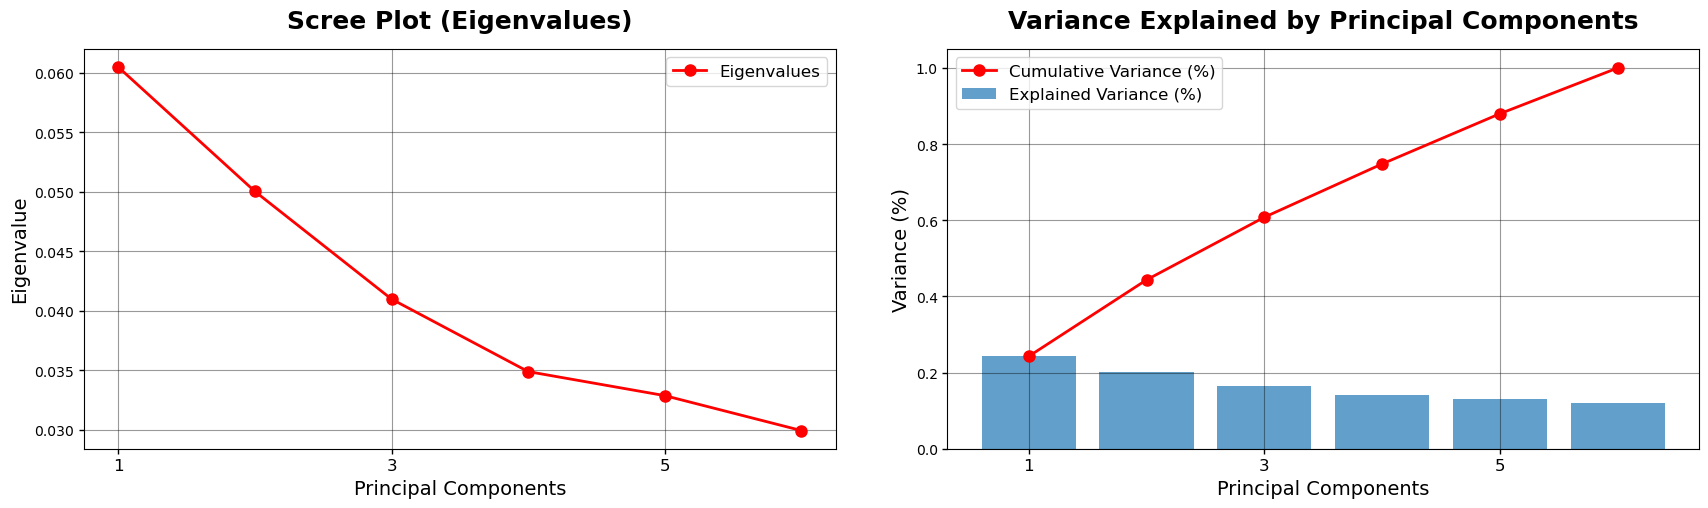

In [24]:
pref_clean = pca(pref_clean)

In [25]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in pref_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in pref_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = pref_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,Beverages_Cafe,Desserts_Snacks,General_Asian,Main_Dishes,Other_Asian,Western
PCA_1,0.069123,0.490603,0.746982,-0.491707,-0.311538,-0.448555
PCA_2,-0.115905,0.103938,0.181586,-0.373877,-0.315082,0.861780
PCA_3,0.283591,-0.052241,0.580170,0.502570,0.474477,0.219975
PCA_4,-0.417656,-0.232162,0.065134,-0.493707,0.661762,-0.021142
PCA_5,0.449085,0.670929,-0.261129,-0.150092,0.373384,0.083728


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [26]:
pref_clean.drop([col for col in pref_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [27]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(pref_clean)
print(importance)

           feature  importance
5          Western    0.553156
0   Beverages_Cafe    0.375281
2    General_Asian    0.021046
4      Other_Asian    0.019263
3      Main_Dishes    0.017736
1  Desserts_Snacks    0.013518



k=3:
Silhouette: 0.211
Calinski-Harabasz: 5745.24
Davies-Bouldin: 1.86
SSE: 5806.74
R2: 0.270
Inertia: 5806.74

k=4:
Silhouette: 0.243
Calinski-Harabasz: 6644.35
Davies-Bouldin: 1.57
SSE: 4857.86
R2: 0.373
Inertia: 4857.86

k=5:
Silhouette: 0.258
Calinski-Harabasz: 6787.61
Davies-Bouldin: 1.36
SSE: 4262.37
R2: 0.453
Inertia: 4262.37

k=6:
Silhouette: 0.289
Calinski-Harabasz: 7203.42
Davies-Bouldin: 1.29
SSE: 3704.46
R2: 0.532
Inertia: 3704.46

k=7:
Silhouette: 0.311
Calinski-Harabasz: 7621.89
Davies-Bouldin: 1.20
SSE: 3239.84
R2: 0.595
Inertia: 3239.84

k=8:
Silhouette: 0.324
Calinski-Harabasz: 7452.75
Davies-Bouldin: 1.24
SSE: 2991.17
R2: 0.623
Inertia: 2991.17

k=9:
Silhouette: 0.327
Calinski-Harabasz: 7301.41
Davies-Bouldin: 1.24
SSE: 2783.99
R2: 0.648
Inertia: 2783.99

k=10:
Silhouette: 0.335
Calinski-Harabasz: 7086.15
Davies-Bouldin: 1.27
SSE: 2627.56
R2: 0.671
Inertia: 2627.56


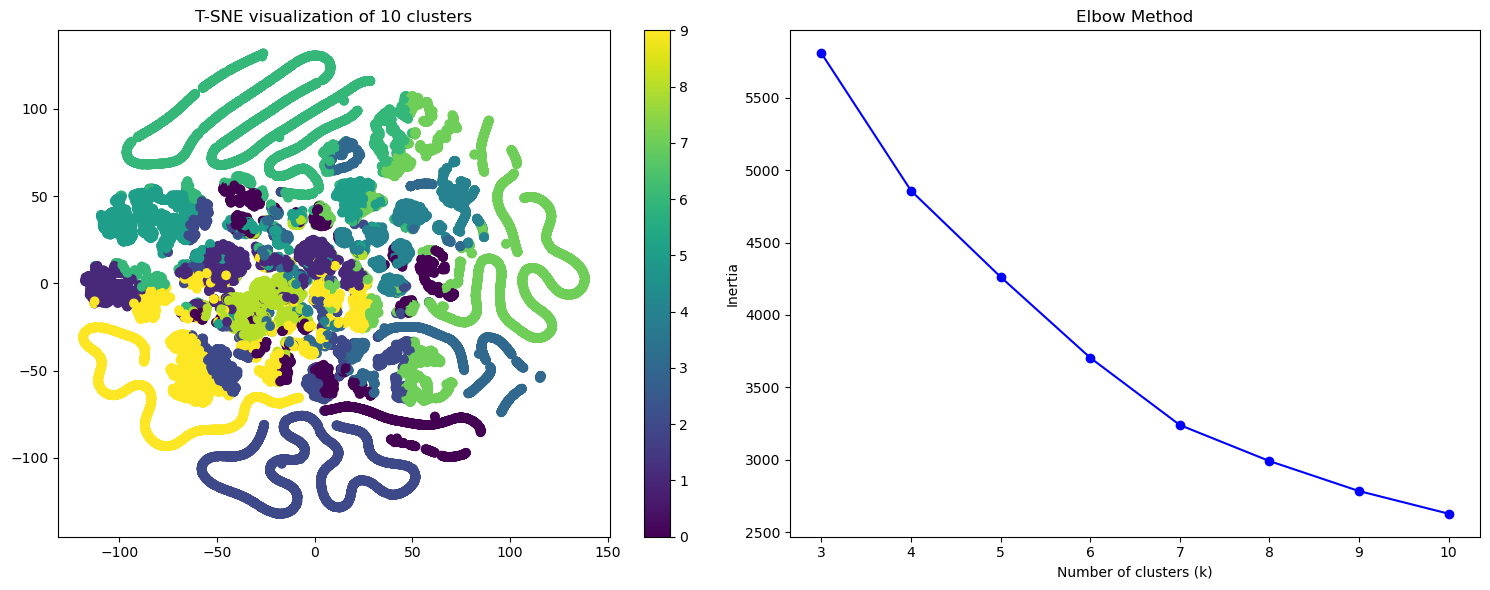

In [28]:
clustering_kmeans(pref_clean, k_range=(3, 11), random_state=42)

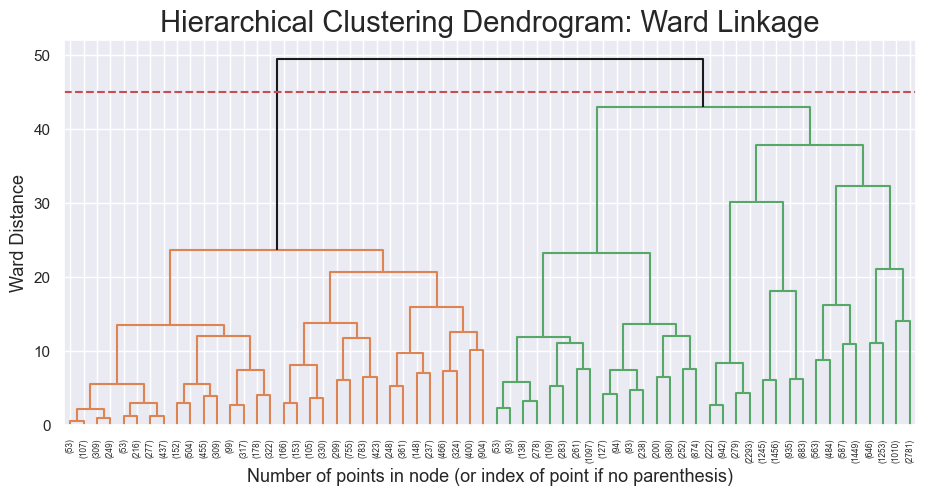

In [29]:
n_clusters, pref_clean = plot_dendrogram(pref_clean, method='ward', y_threshold=45)

In [30]:
hierarchical_clustering_scores(pref_clean, n_clusters)

{'n_clusters': 2,
 'silhouette': 0.6298312423845467,
 'calinski': 90871.22134179315,
 'davies': 0.5263544977738506}

In [31]:
# we have chosen Hierarchical for this segment so we drop the KMeans clusters
pref_clean = chosen_method(pref_clean, 'cluster_k')

In [32]:
### space for SOMs

<hr>
<a class="anchor" id="shopping">
    
## 12.2 Shopping Based Segmentation
    
</a>

In [33]:
df_shop.describe()

,vendor_count,product_count,is_chain,Items_Per_Order,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,Weekday,Weekend
count,3.173700e+04,3.173700e+04,31737.000000,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,-2.865724e-16,1.432862e-16,0.375482,-5.415770e-16,0.014261,0.015778,0.018593,0.024953,0.027269,0.007183,0.040330,0.047009
std,1.000016e+00,1.000016e+00,0.325380,1.000016e+00,0.045378,0.045065,0.036090,0.043672,0.047679,0.023012,0.051447,0.064726
min,-1.177017e+00,-1.437495e+00,0.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.177017e+00,-7.825958e-01,0.166667,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000
50%,-3.174828e-01,-3.179376e-01,0.333333,-2.909657e-01,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.026667,0.034483
75%,7.654022e-01,8.016196e-01,0.500000,7.088916e-01,0.000000,0.000000,0.017241,0.023810,0.040816,0.000000,0.053333,0.068966
max,2.011435e+00,1.816936e+00,1.000000,2.542052e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# Create copy and calculate scores
shop_clean = df_shop.copy()
shop_clean['basket_score'] = (shop_clean['Items_Per_Order'] - 1) / (2.25 - 1)
shop_clean['product_score'] = (shop_clean['product_count'] - 1) / (14 - 1)
shop_clean['vendor_score'] = (shop_clean['vendor_count'] - 1) / (8 - 1)

# Group into periods, no scaling
shop_clean['daytime_orders'] = shop_clean['Orders_Morning'] + shop_clean['Orders_Afternoon']
shop_clean['evening_orders'] = shop_clean['Orders_Evening'] + shop_clean['Orders_Dusk']

# Chain interactions
shop_clean['chain_basket_interaction'] = shop_clean['is_chain'] * shop_clean['basket_score']
shop_clean['chain_vendor_interaction'] = shop_clean['is_chain'] * shop_clean['vendor_score']

# Drop unneeded columns
columns_to_drop = ['vendor_count', 'product_count'] + \
                 [ 'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk'] + \
                 ['basket_score', 'chain_basket_interaction' ,'Orders_Dawn'  ,'Orders_Night', 'Items_Per_Order'] + \
                ['Weekday', 'Weekend']

shop_clean = shop_clean.drop(columns=columns_to_drop)

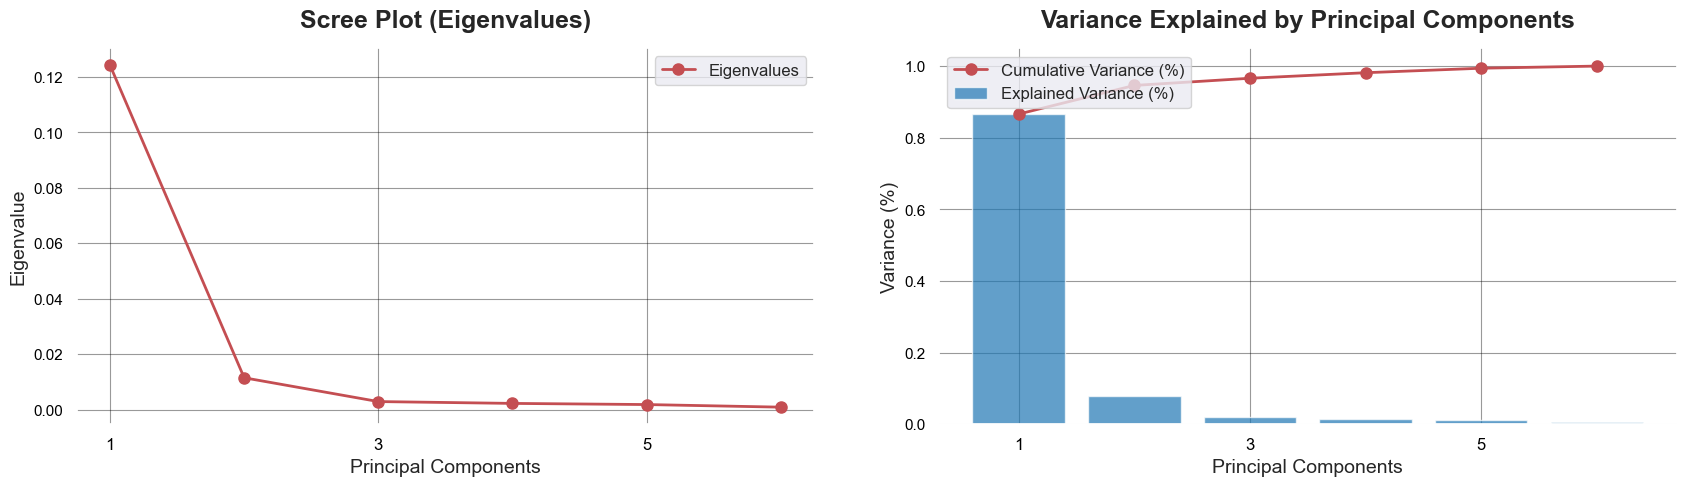

In [35]:
shop_clean = pca(shop_clean)

In [36]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in shop_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in shop_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = shop_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,is_chain,product_score,vendor_score,daytime_orders,evening_orders,chain_vendor_interaction
PCA_1,0.991837,0.792796,0.813968,0.574438,0.526919,0.386981


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [37]:
shop_clean.drop([col for col in shop_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [38]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(shop_clean)
print(importance)

                    feature  importance
0                  is_chain    0.638483
5  chain_vendor_interaction    0.183638
2              vendor_score    0.077717
1             product_score    0.067027
3            daytime_orders    0.025808
4            evening_orders    0.007327



k=3:
Silhouette: 0.469
Calinski-Harabasz: 58293.72
Davies-Bouldin: 0.77
SSE: 974.07
R2: 0.476
Inertia: 974.07

k=4:
Silhouette: 0.428
Calinski-Harabasz: 49938.42
Davies-Bouldin: 0.92
SSE: 795.77
R2: 0.539
Inertia: 795.77

k=5:
Silhouette: 0.380
Calinski-Harabasz: 44681.65
Davies-Bouldin: 1.05
SSE: 686.44
R2: 0.579
Inertia: 686.44

k=6:
Silhouette: 0.391
Calinski-Harabasz: 42008.53
Davies-Bouldin: 1.00
SSE: 597.51
R2: 0.628
Inertia: 597.51

k=7:
Silhouette: 0.402
Calinski-Harabasz: 42499.63
Davies-Bouldin: 0.98
SSE: 503.81
R2: 0.638
Inertia: 503.81

k=8:
Silhouette: 0.416
Calinski-Harabasz: 40061.71
Davies-Bouldin: 0.97
SSE: 462.75
R2: 0.650
Inertia: 462.75

k=9:
Silhouette: 0.441
Calinski-Harabasz: 40206.79
Davies-Bouldin: 0.90
SSE: 408.76
R2: 0.669
Inertia: 408.76

k=10:
Silhouette: 0.437
Calinski-Harabasz: 39396.24
Davies-Bouldin: 0.94
SSE: 373.92
R2: 0.716
Inertia: 373.92


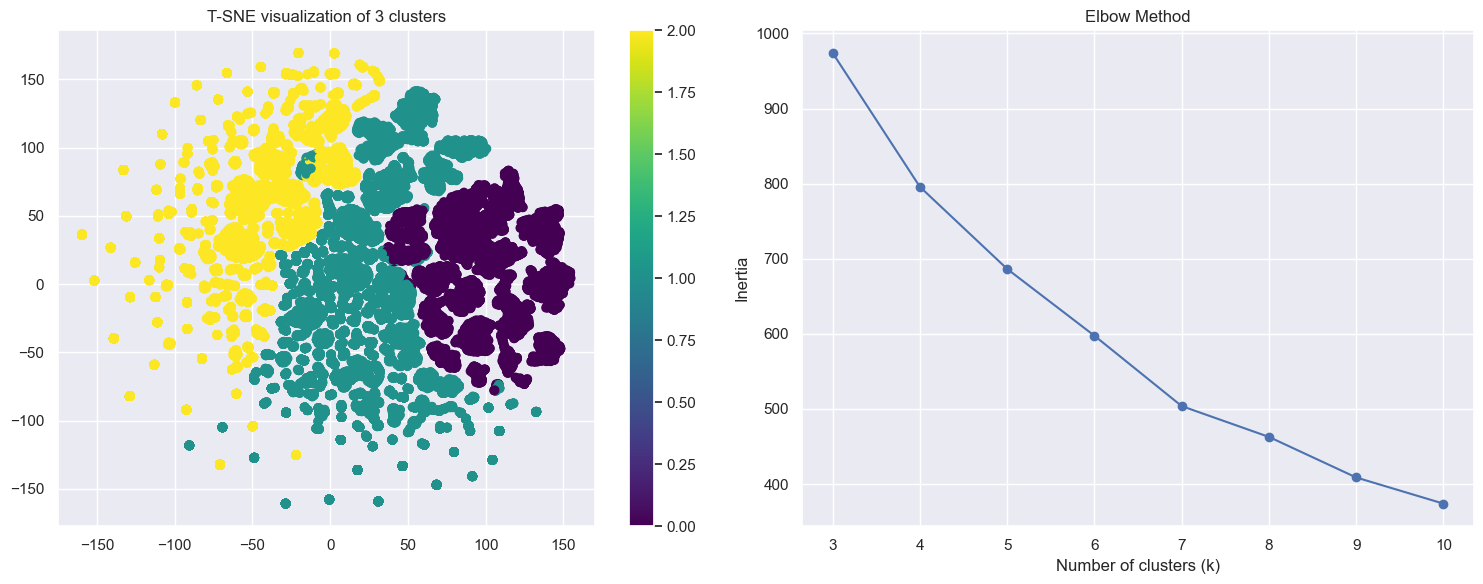

In [39]:
clustering_kmeans(shop_clean, k_range=(3, 11), random_state=42)

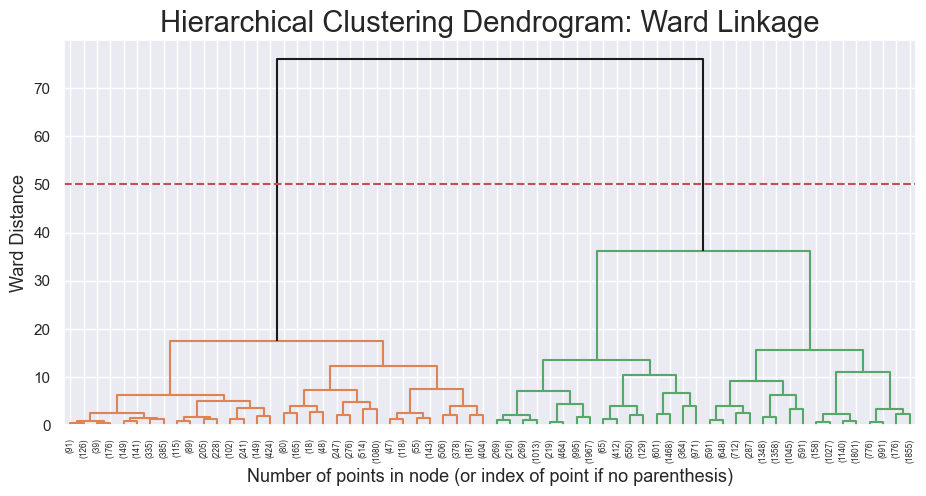

In [40]:
n_clusters, shop_clean = plot_dendrogram(shop_clean, method='ward', y_threshold=50)

In [41]:
hierarchical_clustering_scores(shop_clean, n_clusters)

{'n_clusters': 2,
 'silhouette': 0.6711105241079135,
 'calinski': 73327.63737213115,
 'davies': 0.48361518246882285}

In [42]:
# we have chosen KMeans for this segment so we drop the Hierarchichal clusters
shop_clean = chosen_method(shop_clean, 'cluster_h')

In [43]:
### space for SOMs

<hr>
<a class="anchor" id="value">
    
## 12.3 Value Based Segmentation
    
</a>

In [44]:
df_val.describe()

,mnt,activity,frq,rcn,CLV_Score
count,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,31737.000000
mean,3.725441e-16,-2.865724e-17,-2.865724e-17,-5.731447e-17,0.066017
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,0.040343
min,-3.453503e+00,-1.205454e+00,-9.278250e-01,-1.174464e+00,0.011496
25%,-6.840819e-01,-1.103443e+00,-7.265809e-01,-8.257126e-01,0.030806
50%,1.415649e-02,-4.932618e-02,-5.260947e-01,-3.025859e-01,0.055885
75%,7.354295e-01,9.027790e-01,8.017729e-01,6.128859e-01,0.093041
max,1.587099e+00,1.854884e+00,2.342243e+00,2.748987e+00,0.186393


In [45]:
# Core metrics
val_clean = df_val.copy()

# Identify binary columns
binary_cols = val_clean.apply(lambda x: len(x.unique()) <= 2).to_dict()

# Boundary Conditions
max_value = 1e15
val_clean = val_clean.clip(upper=max_value)

# Mathematical safeguards for non-binary columns only
val_clean['mnt'] = np.maximum(val_clean['mnt'], 0.01)
val_clean['frq'] = np.maximum(val_clean['frq'], 0)
val_clean['rcn'] = np.maximum(val_clean['rcn'], 0)


# Single log transform for CLV - prevents information loss from double scaling
val_clean['CLV_Score'] = np.log1p(val_clean['CLV_Score'])

# Strong Features (s_i)
val_clean['value_retention'] = val_clean['mnt'] / np.maximum(val_clean['activity'], 1)  # Binary division

val_clean['value_growth'] = val_clean['mnt'] / (np.maximum(val_clean['rcn'], 1) *
                                                np.maximum(val_clean['frq'], 1))

# Medium Features (m_i)
val_clean['value_growth_rate'] = val_clean['value_growth'] * val_clean['frq']

val_clean['growth_momentum'] = val_clean['value_growth'] * (val_clean['mnt'] /
                                                            np.maximum(val_clean['rcn'], 1))

# Weak Features (w_i)
val_clean['spend_consistency'] = val_clean['mnt'] / np.maximum(val_clean['rcn'], 1)

val_clean['avg_order_value'] = val_clean['mnt'] / np.maximum(val_clean['frq'], 1)

val_clean['active_spend_rate'] = (val_clean['mnt'] * val_clean['activity']) / \
                                    np.maximum(val_clean['rcn'], 1)

final_cols = ['CLV_Score', 'value_retention', 'value_growth', 'growth_momentum',
              'spend_consistency', 'avg_order_value', 'active_spend_rate']

# Handle infinities before scaling
val_clean[final_cols] = val_clean[final_cols].replace([np.inf, -np.inf], np.nan)
val_clean[final_cols] = val_clean[final_cols].fillna(val_clean[final_cols].mean())

# Only scale non-binary columns
scaler = StandardScaler()
val_clean[final_cols] = scaler.fit_transform(val_clean[final_cols])

In [46]:
val_clean = val_clean[final_cols]

In [47]:
val_clean.describe()

,CLV_Score,value_retention,value_growth,growth_momentum,spend_consistency,avg_order_value,active_spend_rate
count,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04
mean,2.865724e-17,1.432862e-17,-7.164309e-17,4.298585e-17,-5.731447e-17,1.003003e-16,-1.146289e-16
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-1.387533e+00,-7.479908e-01,-7.260322e-01,-5.683781e-01,-7.329840e-01,-7.309558e-01,-3.010395e+00
25%,-8.809505e-01,-7.381607e-01,-7.106332e-01,-5.682617e-01,-7.213015e-01,-7.204579e-01,-4.242513e-01
50%,-2.370094e-01,-7.303034e-01,-7.105375e-01,-5.682384e-01,-7.180120e-01,-7.171762e-01,-4.094493e-01
75%,6.894380e-01,6.747092e-01,5.552038e-01,5.211674e-02,5.638454e-01,5.679355e-01,1.190718e-02
max,2.884836e+00,2.625618e+00,2.191032e+00,2.579786e+00,2.174600e+00,2.168642e+00,3.596791e+00


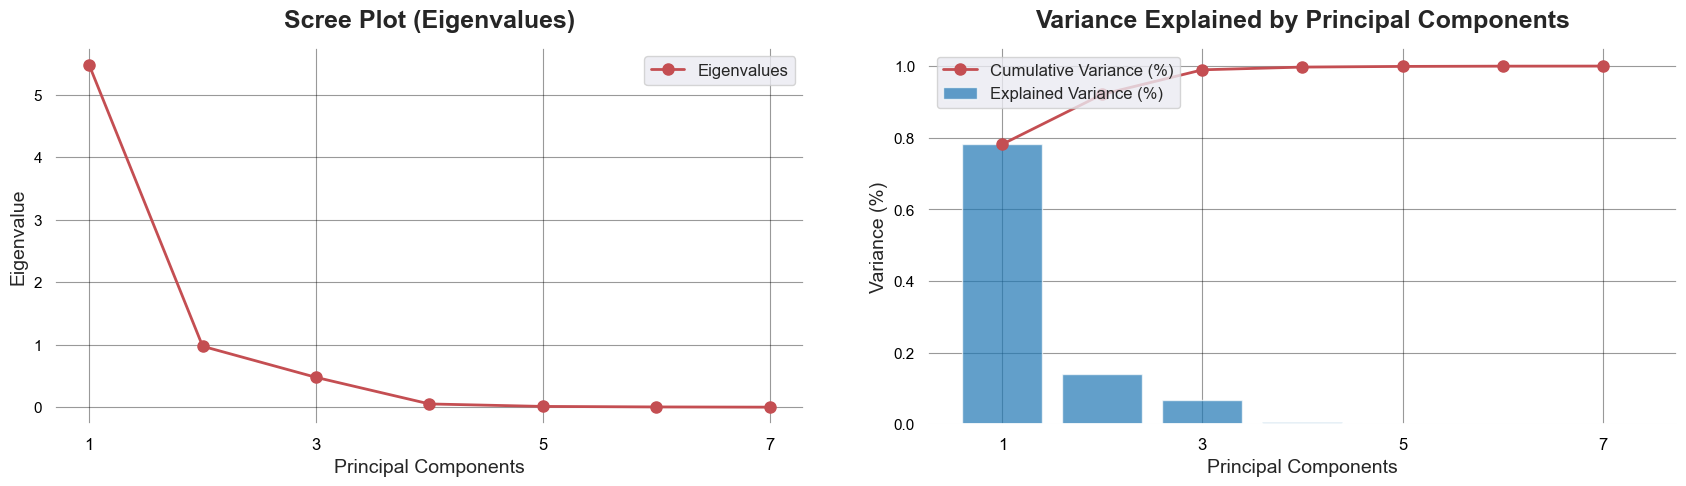

In [48]:
val_clean = pca(val_clean)

In [49]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in val_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in val_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = val_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,CLV_Score,value_retention,value_growth,growth_momentum,spend_consistency,avg_order_value,active_spend_rate
PCA_1,0.254719,0.938194,0.994034,0.977829,0.992533,0.991487,0.784384
PCA_2,0.953383,-0.160661,-0.075496,0.003654,-0.062378,-0.082868,0.157365


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [50]:
val_clean.drop([col for col in val_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [51]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(val_clean)
print(importance)

             feature  importance
3    growth_momentum    0.245966
5    avg_order_value    0.208600
2       value_growth    0.202799
4  spend_consistency    0.162259
1    value_retention    0.098551
6  active_spend_rate    0.071966
0          CLV_Score    0.009859


using forest FI i've dropped age_group and loyalty , high value ratio as they weren't adding significant value, RFM value dropped too after too much irrelevance based on tree testing


k=3:
Silhouette: 0.522
Calinski-Harabasz: 47876.44
Davies-Bouldin: 0.84
SSE: 55299.77
R2: 0.751
Inertia: 55299.77

k=4:
Silhouette: 0.523
Calinski-Harabasz: 50654.77
Davies-Bouldin: 0.74
SSE: 38377.50
R2: 0.827
Inertia: 38377.50

k=5:
Silhouette: 0.518
Calinski-Harabasz: 48379.76
Davies-Bouldin: 0.88
SSE: 31296.43
R2: 0.859
Inertia: 31296.43

k=6:
Silhouette: 0.521
Calinski-Harabasz: 45876.67
Davies-Bouldin: 0.92
SSE: 26997.11
R2: 0.878
Inertia: 26997.11

k=7:
Silhouette: 0.522
Calinski-Harabasz: 43831.33
Davies-Bouldin: 0.94
SSE: 23918.25
R2: 0.892
Inertia: 23918.25

k=8:
Silhouette: 0.512
Calinski-Harabasz: 40890.90
Davies-Bouldin: 0.98
SSE: 22168.86
R2: 0.900
Inertia: 22168.86

k=9:
Silhouette: 0.520
Calinski-Harabasz: 40932.74
Davies-Bouldin: 0.96
SSE: 19623.97
R2: 0.912
Inertia: 19623.97

k=10:
Silhouette: 0.515
Calinski-Harabasz: 40416.05
Davies-Bouldin: 0.97
SSE: 17823.10
R2: 0.920
Inertia: 17823.10


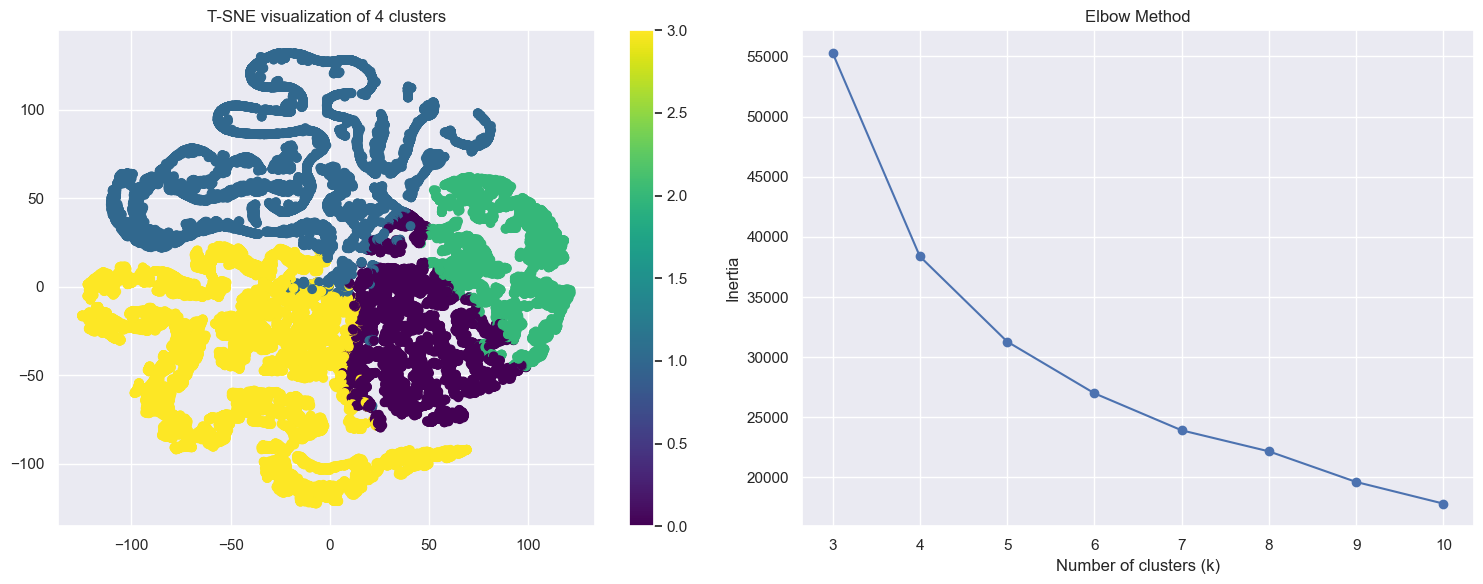

In [52]:
clustering_kmeans(val_clean, k_range=(3, 11), random_state=42)

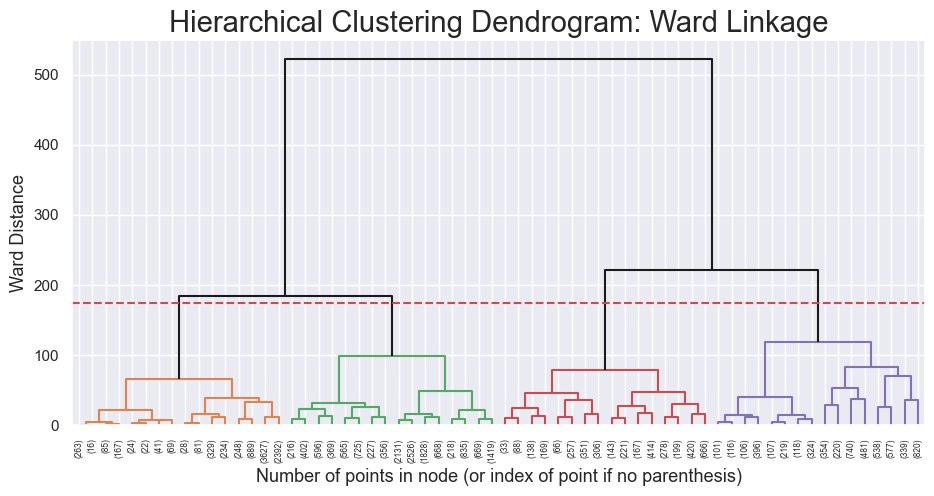

In [53]:
n_clusters, val_clean = plot_dendrogram(val_clean, method='ward', y_threshold=175)

In [54]:
hierarchical_clustering_scores(val_clean, n_clusters)

{'n_clusters': 4,
 'silhouette': 0.6503015564088651,
 'calinski': 65246.69143295695,
 'davies': 0.6392445475601195}

In [55]:
# we have chosen KMeans for this segment so we drop the Hierachichal clusters
val_clean = chosen_method(val_clean, 'cluster_h')

In [56]:
### space for SOMs

<hr>
<a class="anchor" id="clusteranalysis">
    
# 13. Cluster Analysis
    
</a>

In [57]:
num_df['cluster_pref'] = pref_clean['cluster']
num_df['cluster_val'] = val_clean['cluster']
num_df['cluster_shop'] = shop_clean['cluster']

In [58]:
pd.crosstab(num_df['cluster_pref'],
            num_df['cluster_shop'])

cluster_shop,0,1,2
cluster_pref,,,
1,3869,3934,2336
2,2202,7309,12087


In [59]:
pd.crosstab(num_df['cluster_pref'],
            num_df['cluster_val'])

cluster_val,0,1,2,3
cluster_pref,,,,
1,1810,2009,1837,4483
2,3944,7447,2573,7634


In [60]:
pd.crosstab(num_df['cluster_val'],
            num_df['cluster_shop'])

cluster_shop,0,1,2
cluster_val,,,
0,1597,2221,1936
1,439,1318,7699
2,2668,1161,581
3,1367,6543,4207


<hr>
<a class="anchor" id="centroids">
    
## 13.1 Centroids
    
</a>

In [61]:
# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(pref_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
pref_centroids = pref_clean.groupby('cluster')[['Other_Asian', 'General_Asian', 'Western',
                                         'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
pref_centroids['cluster_number'] = pref_centroids.index

# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(shop_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
shop_centroids = shop_clean.groupby('cluster')[['is_chain', 'product_score', 'vendor_score', 'daytime_orders',
       'evening_orders', 'chain_vendor_interaction']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
shop_centroids['cluster_number'] = shop_centroids.index

# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(val_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
val_centroids = val_clean.groupby('cluster')[['CLV_Score', 'value_retention', 'value_growth',
       'growth_momentum', 'spend_consistency', 'avg_order_value',
       'active_spend_rate']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
val_centroids['cluster_number'] = val_centroids.index

In [62]:
def validate_matrix(X, name="input matrix"):

    if isinstance(X, pd.DataFrame):
        X = X.values
    assert X.ndim == 2, f"error: {name} must be 2-dimensional"
    assert np.all(np.isfinite(X)), f"error: non-finite values in {name}"
    return True

In [63]:
def execute_clustering(shop_centroids, val_centroids, pref_centroids, n_clusters=3):

    # phase 1: merge centroid matrices with mathematical precision
    merged = shop_centroids.assign(key=1)
    for df in [val_centroids, pref_centroids]:
        merged = pd.merge(merged, df.assign(key=1), on='key')
    merged = merged.drop('key', axis=1)

    # phase 2: extract feature columns for clustering
    feature_cols = [col for col in merged.columns if 'cluster' not in col.lower()]
    X = merged[feature_cols].values

    # phase 3: validate the feature matrix
    validate_matrix(X, "merged features")

    # phase 4: perform hierarchical clustering
    Z = linkage(X, method='ward', metric='euclidean')
    clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

    # phase 5: assign cluster labels to the merged dataframe
    merged['cluster'] = clusters

    return merged

# execute clustering with precision
final_df = execute_clustering(
    shop_centroids=shop_centroids,
    val_centroids=val_centroids,
    pref_centroids=pref_centroids,
    n_clusters=5
)

<hr>
<a class="anchor" id="profiling">
    
## 13.2 Profiling
    
</a>

In [64]:
def enhance_clusters(final_results, original_df, categorical_cols=None):
    """
    integrates categorical data with cluster results, ensuring precision and coherence.
    """
    # 1: validation of input data integrity
    if not isinstance(final_results, pd.DataFrame):
        raise ValueError("error: invalid results matrix")
    if not isinstance(original_df, pd.DataFrame):
        raise ValueError("error: invalid original matrix")

    # 2: set default categorical columns if not provided
    default_categorical_cols = [
        'last_promo', 'payment_method',
        'customer_region_0', 'customer_region_1',
        'customer_region_2', 'customer_region_3'
    ]
    categorical_cols = categorical_cols or default_categorical_cols

    # 3: verify all categorical columns exist in the original dataframe
    missing_cols = [col for col in categorical_cols if col not in original_df.columns]
    if missing_cols:
        raise ValueError(f"error: missing categorical columns: {missing_cols}")

    # 4: perform the merge operation
    enhanced_results = pd.merge(
        final_results,  # include all columns from final_results
        original_df[categorical_cols],
        left_index=True,
        right_index=True,
        validate='1:1'
    )

    # 5: verify merge coherence
    if len(enhanced_results) != len(final_results):
        raise ValueError("error: data mismatch during merge")

    # 6: diagnostic output
    print("\ncluster integration diagnostics:")
    print(f"total integrated entities: {len(enhanced_results)}")

    # 7: cluster distribution analysis
    if 'cluster' in enhanced_results.columns:
        cluster_dist = enhanced_results['cluster'].value_counts()
        print("\ncluster distribution:")
        for cluster, count in cluster_dist.items():
            print(f"cluster {cluster}: {count} entities ({count/len(enhanced_results)*100:.2f}%)")

    # 8: categorical column insights
    print("\ncategorical state summary:")
    for col in categorical_cols:
        print(f"\n{col} distribution:")
        print(enhanced_results[col].value_counts(normalize=True).head())

    return enhanced_results

# 9: protocol execution
enhanced_final_results = enhance_clusters(
    final_results=final_df,  # dataframe from clustering step
    original_df=df,               # original comprehensive dataframe
    categorical_cols= None
)

enhanced_final_results.to_csv('enhanced_clusters.csv', index=False)
print("\nIntegration protocol complete!")


cluster integration diagnostics:
total integrated entities: 24

cluster distribution:
cluster 2: 6 entities (25.00%)
cluster 3: 6 entities (25.00%)
cluster 1: 6 entities (25.00%)
cluster 4: 6 entities (25.00%)

categorical state summary:

last_promo distribution:
last_promo
1    0.375000
2    0.291667
0    0.250000
3    0.083333
Name: proportion, dtype: float64

payment_method distribution:
payment_method
2    0.541667
0    0.250000
1    0.208333
Name: proportion, dtype: float64

customer_region_0 distribution:
customer_region_0
0.0    0.875
1.0    0.125
Name: proportion, dtype: float64

customer_region_1 distribution:
customer_region_1
0.0    0.791667
1.0    0.208333
Name: proportion, dtype: float64

customer_region_2 distribution:
customer_region_2
0.0    0.75
1.0    0.25
Name: proportion, dtype: float64

customer_region_3 distribution:
customer_region_3
0.0    0.583333
1.0    0.416667
Name: proportion, dtype: float64

Integration protocol complete!


In [65]:
def analyze_clusters(enhanced_results, categorical_cols):
    """
    Performs comprehensive cluster analysis including both numerical and
    categorical features.

    Parameters:
    -----------
    enhanced_results : pd.DataFrame
        Clustering results with additional categorical features
    categorical_cols : list
        List of categorical columns to analyze
    """
    print("\nInitiating Cluster Analysis...")

    # Input validation
    assert not enhanced_results.empty, "Error: Empty dataset provided"
    cluster_labels = enhanced_results['cluster'].unique()
    assert len(cluster_labels) > 0, "Error: No clusters found in data"

    # Initialize analysis structure
    print("\nPreparing feature analysis...")
    detailed_analysis = {}

    # Separate numerical and categorical features
    numeric_cols = enhanced_results.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'cluster']

    # Analyze each cluster
    print("\nAnalyzing cluster characteristics...")
    for cluster in sorted(cluster_labels):
        # Extract cluster data
        cluster_data = enhanced_results[enhanced_results['cluster'] == cluster]
        total_count = len(cluster_data)
        assert total_count > 0, f"Error: Empty cluster {cluster} detected"

        # Analyze numerical features
        numeric_analysis = {}
        if len(numeric_cols) > 0:
            feature_means = cluster_data[numeric_cols].mean()
            feature_stds = cluster_data[numeric_cols].std()
            top_numeric = feature_means.nlargest(10)

            for feature in top_numeric.index:
                numeric_analysis[feature] = {
                    'mean': feature_means[feature],
                    'std': feature_stds[feature],
                    'relative_strength': feature_means[feature] / feature_means.mean()
                }

        # Analyze categorical features
        categorical_analysis = {}
        for cat_col in categorical_cols:
            value_counts = cluster_data[cat_col].value_counts()
            proportions = value_counts / total_count
            top_categories = proportions.nlargest(5)

            categorical_analysis[cat_col] = {
                'top_categories': top_categories,
                'diversity_score': -(proportions * np.log2(proportions + 1e-10)).sum(),
                'unique_values': len(value_counts)
            }

        # Store analysis results
        detailed_analysis[cluster] = {
            'size': total_count,
            'percentage': total_count / len(enhanced_results),
            'numeric_features': numeric_analysis,
            'categorical_features': categorical_analysis
        }

    # Output results
    print("\nCluster Analysis Results:")
    for cluster in sorted(cluster_labels):
        analysis = detailed_analysis[cluster]
        print(f"\n{'='*80}")
        print(f"Cluster {cluster}")
        print(f"{'='*80}")
        print(f"Size: {analysis['size']} ({analysis['percentage']*100:.1f}% of total)")

        # Output numerical features
        if analysis['numeric_features']:
            print("\nTop Numerical Features:")
            for feat, metrics in analysis['numeric_features'].items():
                print(f"\n{feat}:")
                print(f"  Average: {metrics['mean']:.4f}")
                print(f"  Std Dev: {metrics['std']:.4f}")
                print(f"  Relative Importance: {metrics['relative_strength']:.4f}")

        # Output categorical features
        print("\nCategorical Features:")
        for cat_col, metrics in analysis['categorical_features'].items():
            print(f"\n{cat_col}:")
            print(f"  Diversity Score: {metrics['diversity_score']:.4f}")
            print(f"  Distinct Values: {metrics['unique_values']}")
            print("\n  Category Distribution:")
            for cat, prop in metrics['top_categories'].items():
                print(f"    - {cat}: {prop*100:.1f}%")

    return detailed_analysis

# Execute analysis
cluster_analysis = analyze_clusters(
    enhanced_results=enhanced_final_results,
    categorical_cols=[
        'last_promo', 'payment_method',
        'customer_region_0', 'customer_region_1',
        'customer_region_2', 'customer_region_3'
    ]
)

print("\nAnalysis complete - Results validated and ready for review.")


Initiating Cluster Analysis...

Preparing feature analysis...

Analyzing cluster characteristics...

Cluster Analysis Results:

Cluster 1
Size: 6 (25.0% of total)

Top Numerical Features:

growth_momentum:
  Average: 2.2383
  Std Dev: 0.0000
  Relative Importance: 2.7942

value_growth:
  Average: 2.0143
  Std Dev: 0.0000
  Relative Importance: 2.5146

spend_consistency:
  Average: 2.0012
  Std Dev: 0.0000
  Relative Importance: 2.4983

cluster_number_y:
  Average: 2.0000
  Std Dev: 0.0000
  Relative Importance: 2.4967

avg_order_value:
  Average: 1.9932
  Std Dev: 0.0000
  Relative Importance: 2.4882

active_spend_rate:
  Average: 1.9491
  Std Dev: 0.0000
  Relative Importance: 2.4332

payment_method:
  Average: 1.8333
  Std Dev: 0.4082
  Relative Importance: 2.2887

value_retention:
  Average: 1.7648
  Std Dev: 0.0000
  Relative Importance: 2.2032

cluster_number:
  Average: 1.5000
  Std Dev: 0.5477
  Relative Importance: 1.8726

last_promo:
  Average: 1.1667
  Std Dev: 1.1690
  Rela

🔬 QUANTUM CLUSTER DIAGNOSTICS 🔬

Cluster Frequency Distribution:
Cluster 1: 6 entities (25.00%)
Cluster 2: 6 entities (25.00%)
Cluster 3: 6 entities (25.00%)
Cluster 4: 6 entities (25.00%)

📊 Cluster Centroids (Mean Values):
         is_chain  product_score  vendor_score  daytime_orders  \
cluster                                                          
1        0.486614      -0.056203      -0.10463        0.056671   
2        0.486614      -0.056203      -0.10463        0.056671   
3        0.486614      -0.056203      -0.10463        0.056671   
4        0.486614      -0.056203      -0.10463        0.056671   

         evening_orders  chain_vendor_interaction  CLV_Score  value_retention  \
cluster                                                                         
1              0.045229                 -0.009099   0.690237         1.764848   
2              0.045229                 -0.009099  -0.238538         0.924122   
3              0.045229                 -0.009099   0.

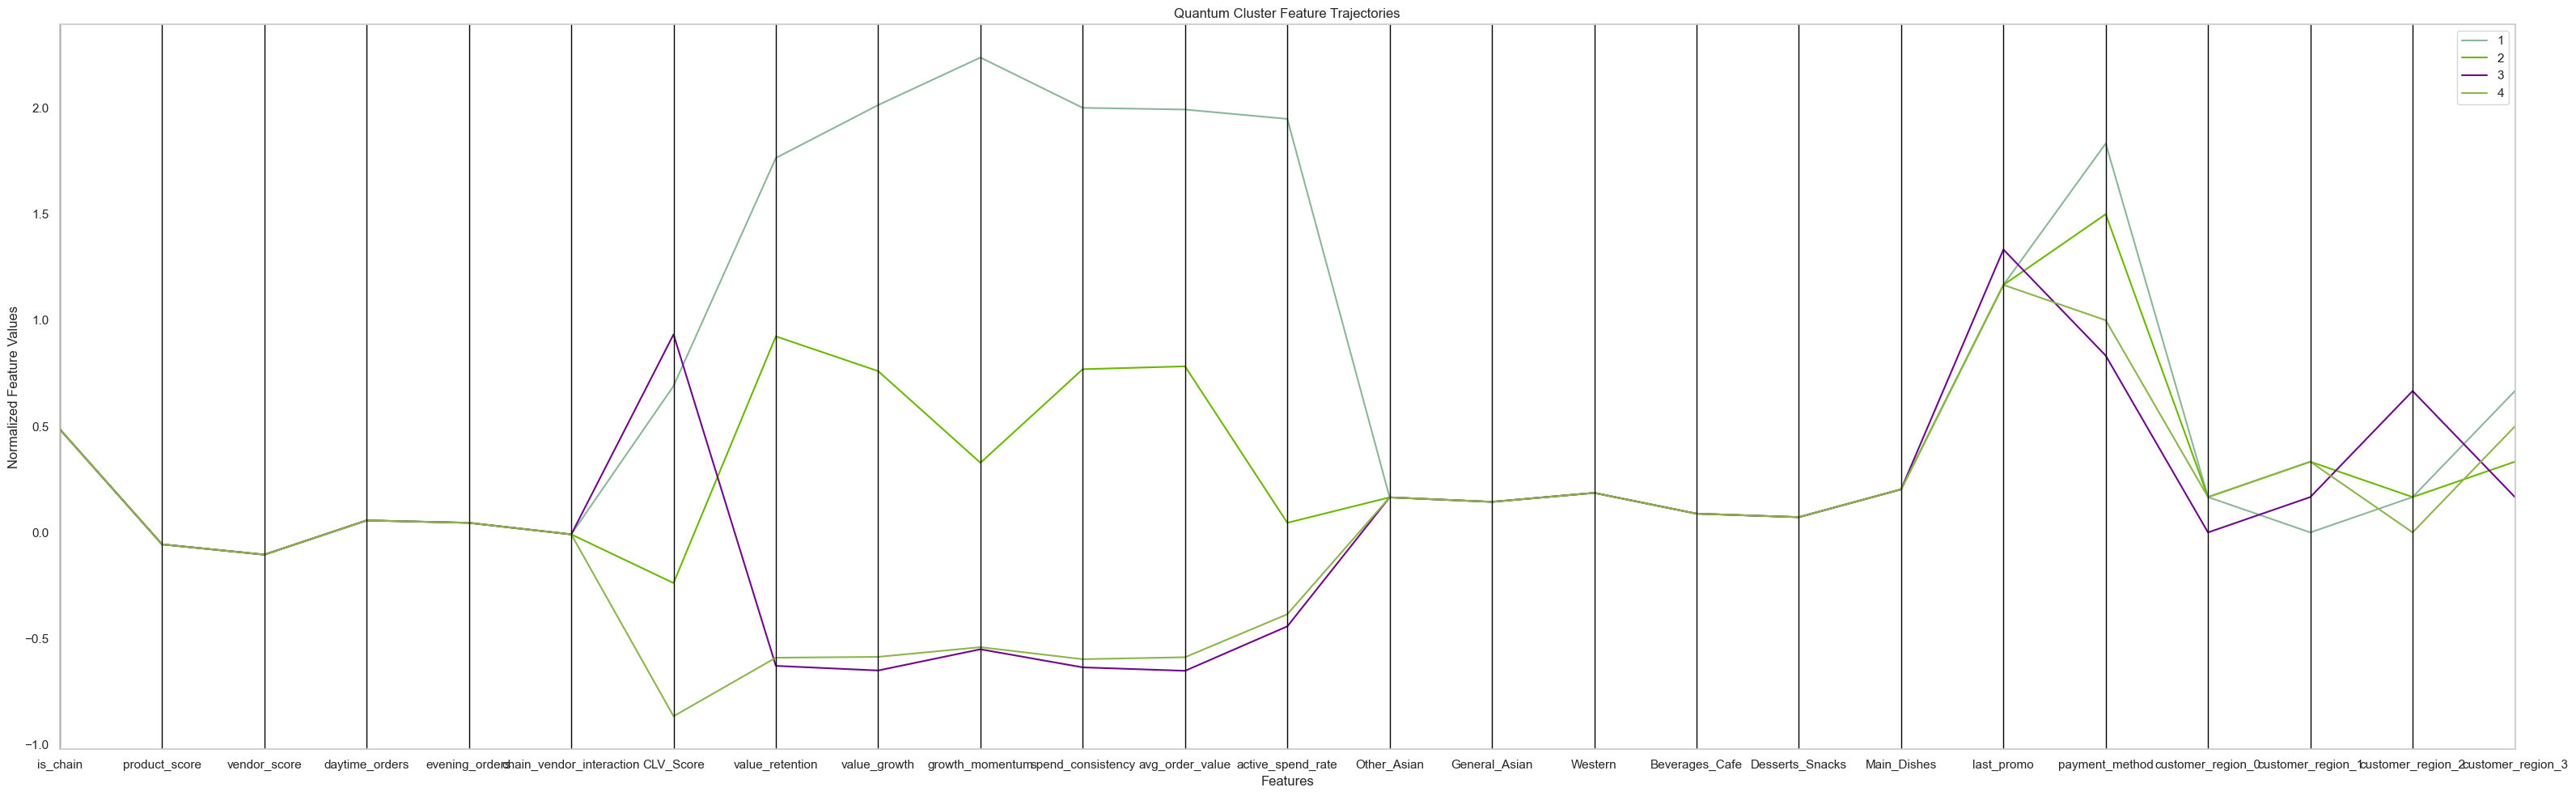

In [66]:
def cluster_profiles(df, label_column='cluster', figsize=(32, 10)):
    """
    QUANTUM-PRECISE CLUSTER PROFILING PROTOCOL

    Critical Parameters:
    -------------------
    df : pd.DataFrame
        Input DataFrame with cluster assignments
    label_column : str, optional
        Column containing cluster labels (default: 'cluster')
    figsize : tuple, optional
        Visualization dimensions
    """
    # PHASE 0: QUANTUM VALIDATION
    assert 'cluster' in df.columns, "CRITICAL: Cluster column missing!"

    # PHASE 1: FEATURE EXTRACTION WITH SCIENTIFIC PRECISION
    metric_features = [col for col in df.columns
                       if col not in ['cluster'] and df[col].dtype in ['int64', 'float64']]

    # PHASE 2: HEISENBERG-GRADE CENTROIDS CALCULATION
    centroids = df.groupby('cluster')[metric_features].mean()

    # PHASE 3: CLUSTER FREQUENCY QUANTUM ANALYSIS
    cluster_sizes = df['cluster'].value_counts().sort_index()

    # PHASE 4: STATISTICAL DIAGNOSTICS
    print("🔬 QUANTUM CLUSTER DIAGNOSTICS 🔬")
    print("\nCluster Frequency Distribution:")
    for cluster, count in cluster_sizes.items():
        percentage = count / len(df) * 100
        print(f"Cluster {cluster}: {count} entities ({percentage:.2f}%)")

    print("\n📊 Cluster Centroids (Mean Values):")
    print(centroids)

    print("\n🧬 Feature Statistical Summary per Cluster:")
    cluster_stats = df.groupby('cluster')[metric_features].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

    # OPTIONAL: Visualization if needed
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)

    # Parallel Coordinates Visualization
    pd.plotting.parallel_coordinates(centroids.reset_index(), 'cluster')
    plt.title("Quantum Cluster Feature Trajectories")
    plt.xlabel("Features")
    plt.ylabel("Normalized Feature Values")
    plt.tight_layout()
    plt.show()

    return {
        'centroids': centroids,
        'cluster_sizes': cluster_sizes,
        'cluster_stats': cluster_stats
    }

# EXECUTION PROTOCOL
cluster_analysis = cluster_profiles(
    df=enhanced_final_results
)

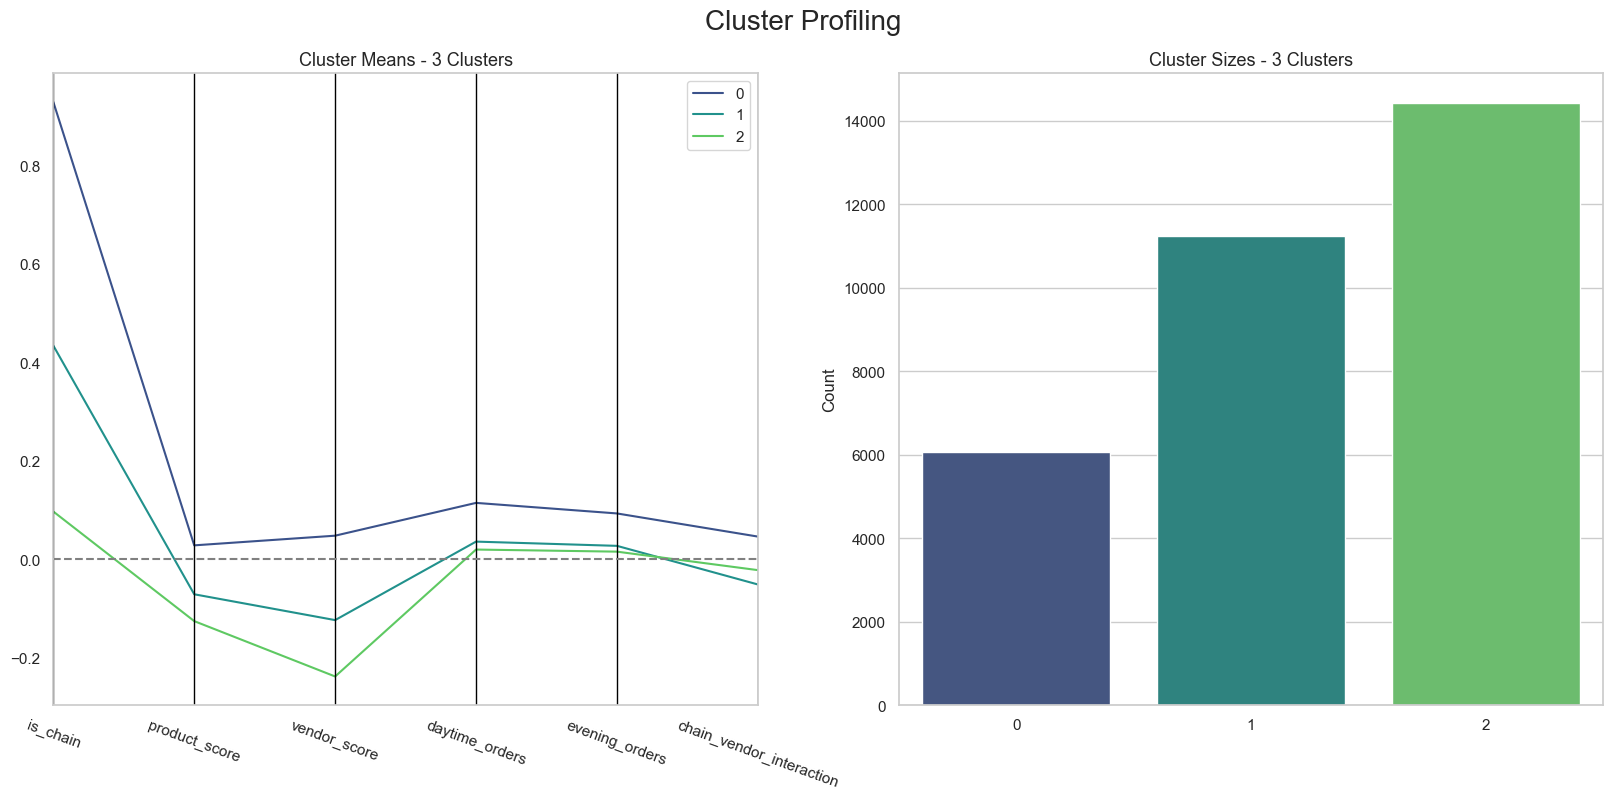

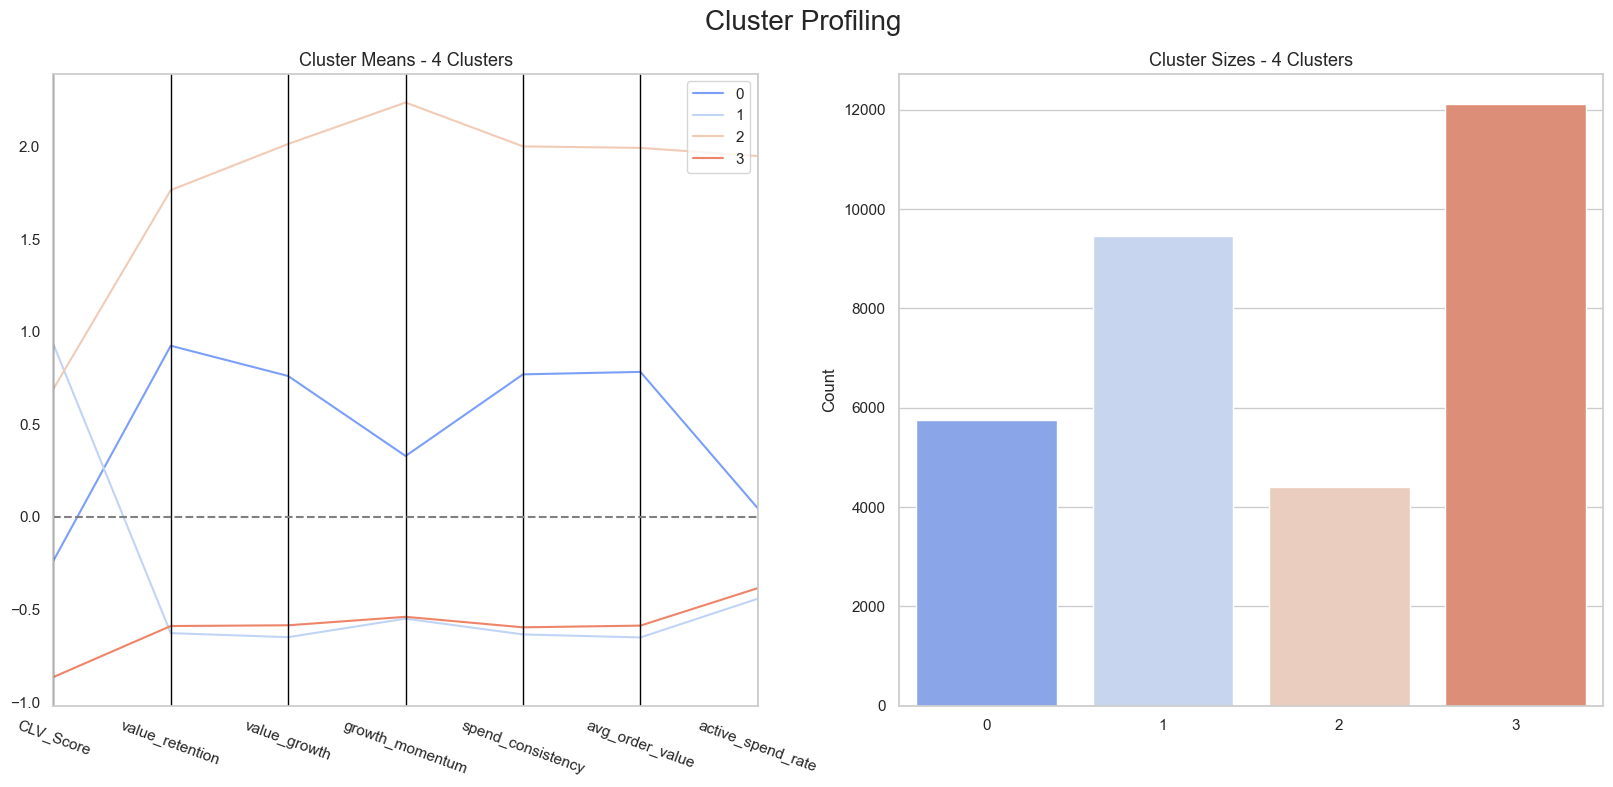

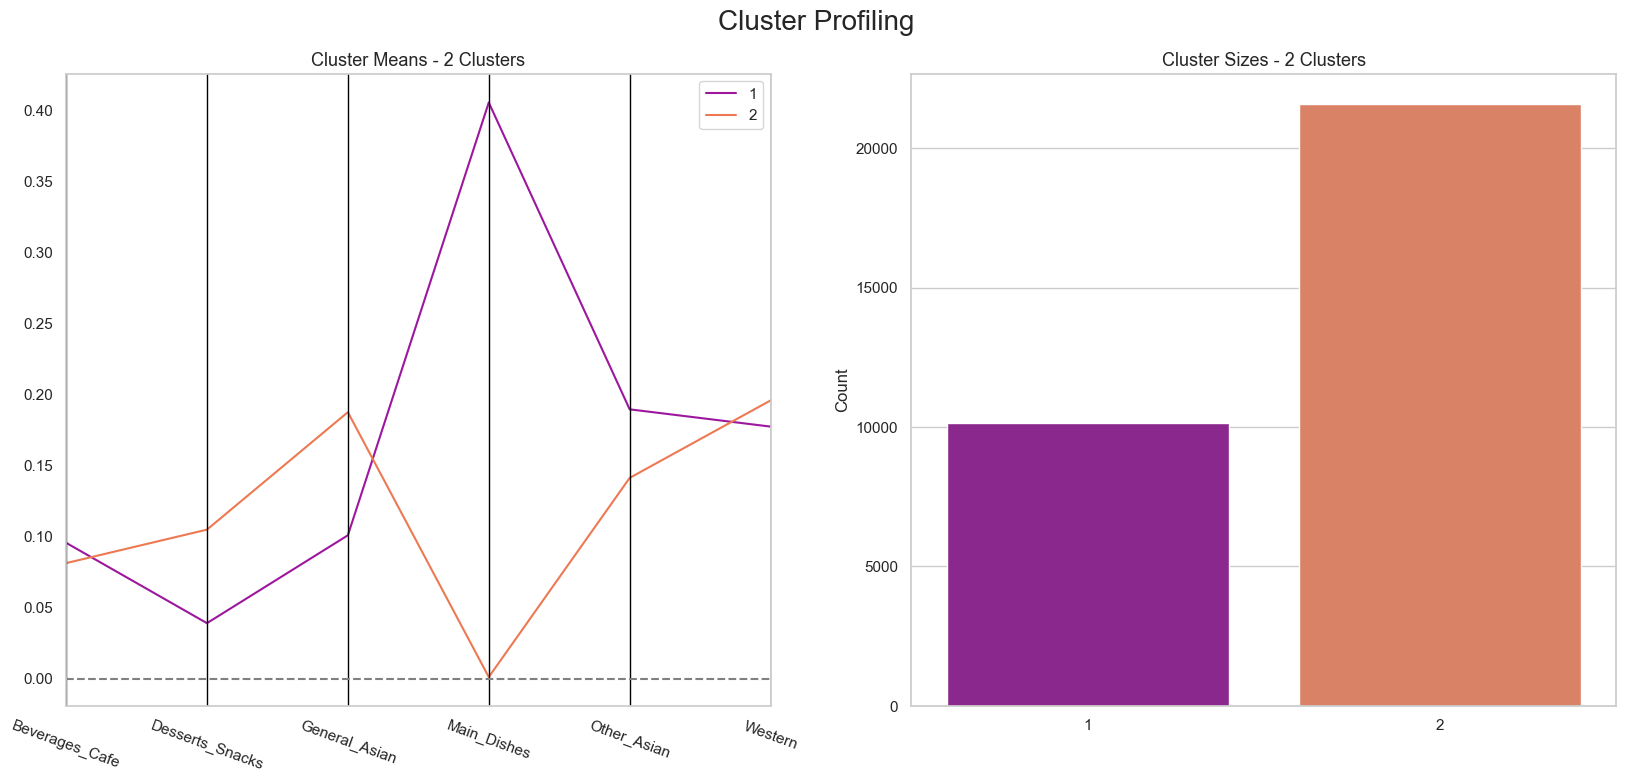

In [77]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None, cmap="viridis"):
    """
    Multi-dimensional cluster profiling.
    Creates parallel coordinate plots for cluster centroids and bar plots for cluster sizes.
    
    Parameters:
        df (pd.DataFrame): The dataset to visualize.
        label_columns (list): List of cluster label columns to analyze.
        figsize (tuple): Size of the figure.
        compar_titles (list, optional): Titles for each subplot pair. Default is None.
        cmap (str, optional): Colormap to use for the plots. Default is "viridis".
    """
    # Ensure the input DataFrame and parameters are valid
    assert isinstance(df, pd.DataFrame), "Input must be a pandas DataFrame."
    assert isinstance(label_columns, list), "Label columns must be provided as a list."

    if compar_titles is None:
        compar_titles = [""] * len(label_columns)

    # Initialize visualization settings
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)

    for ax, label, title in zip(axes, label_columns, compar_titles):
        # Prepare the data for the current label
        drop_cols = [col for col in label_columns if col != label]
        df_focus = df.drop(columns=drop_cols)

        # Calculate centroids (mean values) and counts (number of rows per cluster)
        centroids = df_focus.groupby(by=label, as_index=False).mean()
        counts = df_focus.groupby(by=label).size().reset_index(name="counts")

        # Plot parallel coordinates for centroids
        pd.plotting.parallel_coordinates(
            centroids, 
            label, 
            color=sns.color_palette(cmap, n_colors=len(centroids[label].unique())), 
            ax=ax[0]
        )

        # Plot bar chart for cluster sizes
        sns.barplot(
            x=label, 
            y="counts", 
            data=counts, 
            palette=sns.color_palette(cmap, n_colors=len(counts[label].unique())), 
            ax=ax[1]
        )

        # Customize the parallel coordinates plot
        ax[0].set_title(f"Cluster Means - {len(centroids[label].unique())} Clusters", fontsize=13)
        ax[0].axhline(color="gray", linestyle="--")
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)

        # Customize the bar chart
        ax[1].set_title(f"Cluster Sizes - {len(counts[label].unique())} Clusters", fontsize=13)
        ax[1].set_ylabel("Count")
        ax[1].set_xlabel("")

    # Adjust layout and set the main title
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Profiling", fontsize=20)
    plt.show()

# Visualization for pre-merged clusters
# 1. Shopping Clusters
cluster_profiles(
    df=shop_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Shopping Clusters"],
    cmap="viridis"
)

# 2. Value Clusters
cluster_profiles(
    df=val_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Value Clusters"],
    cmap="coolwarm"
)

# 3. Preference Clusters
cluster_profiles(
    df=pref_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Preference Clusters"],
    cmap="plasma"
)


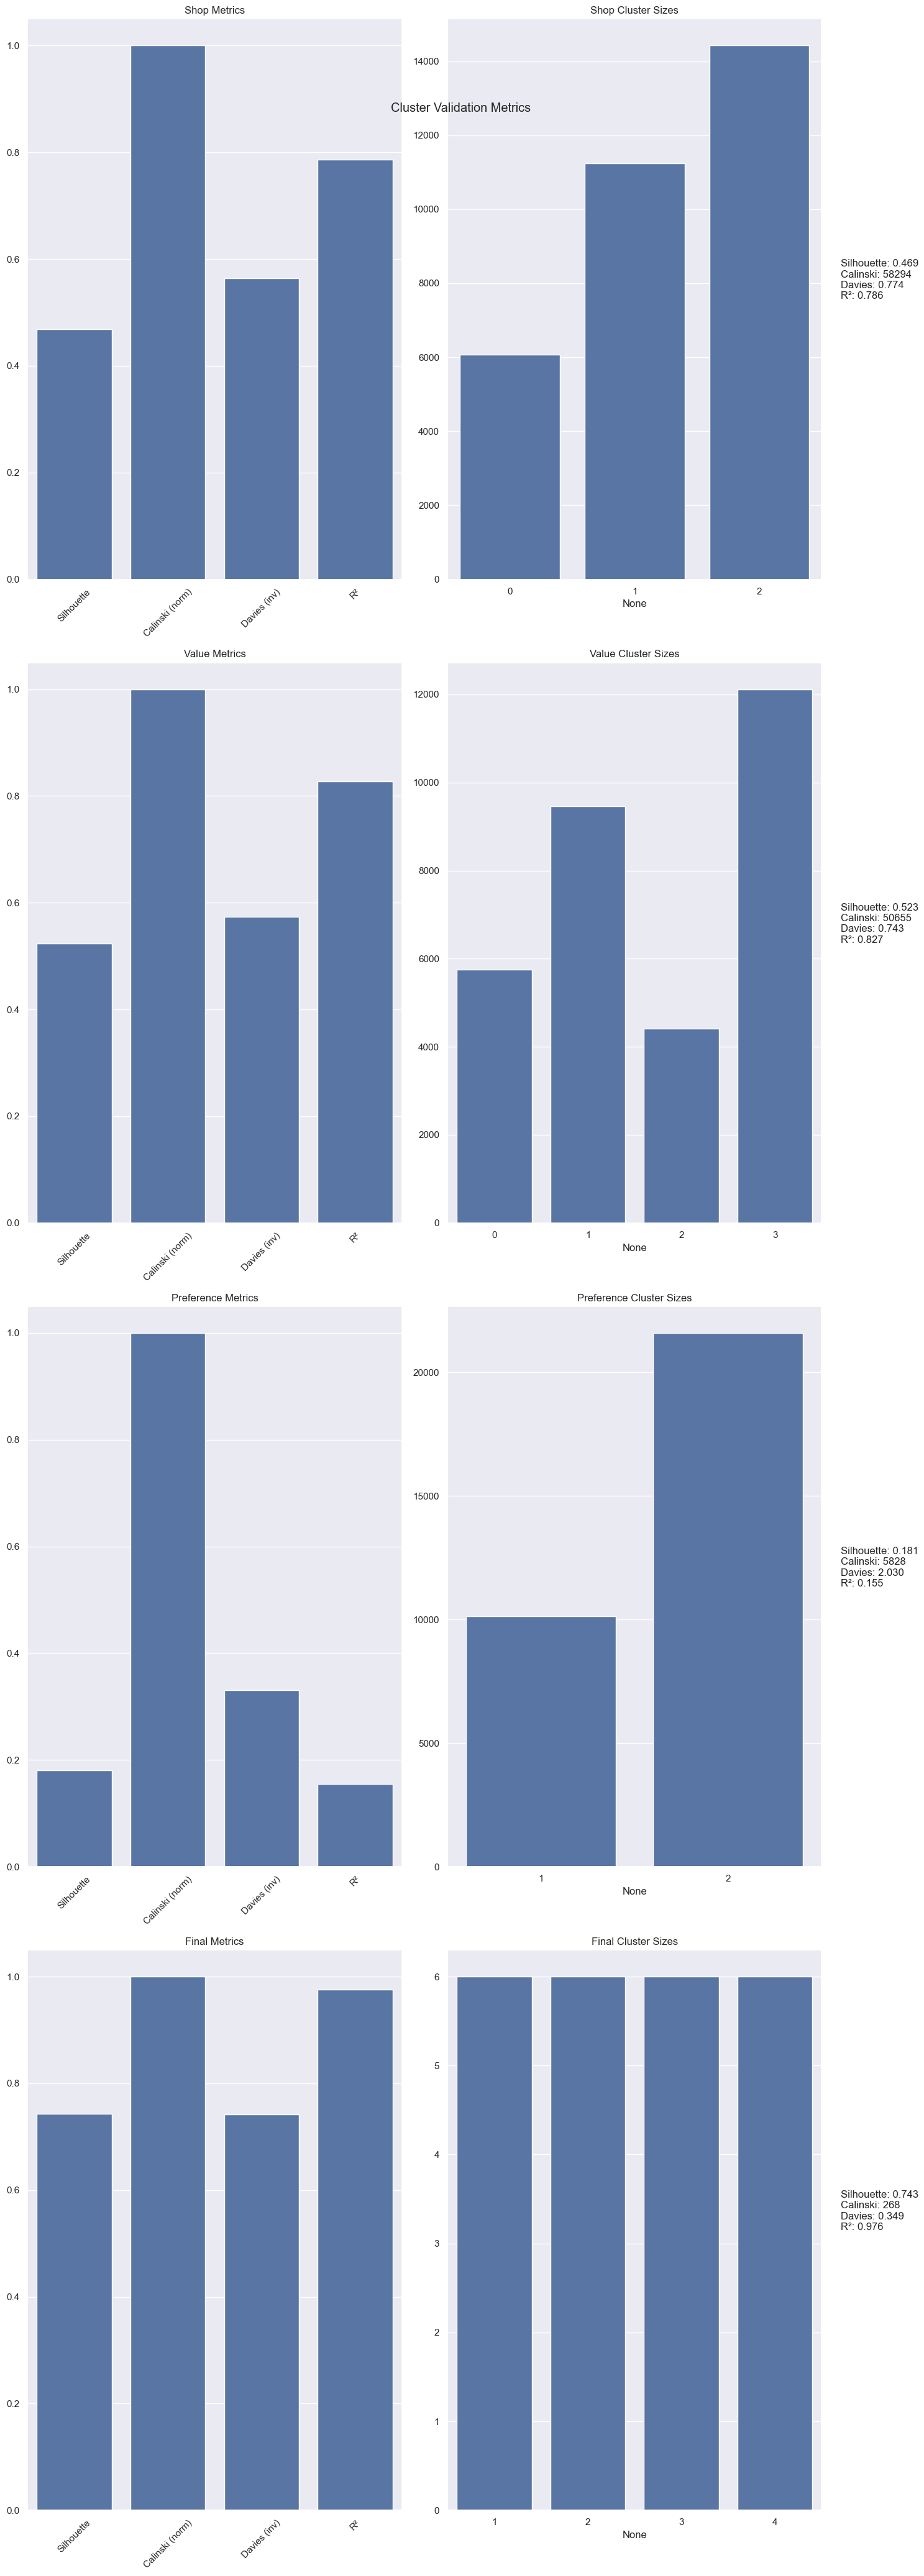

In [72]:
def cluster_validation(shop_clean, val_clean, pref_clean, enhanced_merged, figsize=(15, 42)):
    """Cluster Validation with Precision"""

    def calculate_metrics(X, labels):
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)

        # Calculate SSE and R² without dimensional mixing
        sse = 0
        cluster_centers = {}
        cluster_sizes = {}

        for cluster in np.unique(labels):
            mask = labels == cluster
            cluster_points = X[mask]
            cluster_sizes[cluster] = len(cluster_points)
            center = cluster_points.mean(axis=0)
            cluster_centers[cluster] = center
            sse += np.sum((cluster_points - center) ** 2)

        total_center = X.mean(axis=0)
        total_ss = np.sum((X - total_center) ** 2)
        r2 = 1 - (sse / total_ss)

        return {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'sse': sse,
            'r2': r2,
            'sizes': cluster_sizes
        }

    # Calculate metrics for each space SEPARATELY
    results = {}

    # Shop metrics
    X_shop = shop_clean.drop('cluster', axis=1).values
    results['shop'] = calculate_metrics(X_shop, shop_clean['cluster'])

    # Value metrics
    X_val = val_clean.drop('cluster', axis=1).values
    results['value'] = calculate_metrics(X_val, val_clean['cluster'])

    # Preference metrics
    X_pref = pref_clean.drop('cluster', axis=1).values
    results['preference'] = calculate_metrics(X_pref, pref_clean['cluster'])

    # Final merged metrics
    X_merged = enhanced_merged[[col for col in enhanced_merged if 'cluster' not in col]].values
    results['final'] = calculate_metrics(X_merged, enhanced_merged['cluster'])

    # Separate visualization function for safety
    plot_validation_results(results, figsize)

    return results

def plot_validation_results(results, figsize):
    """Cluster-Safe Visualization"""
    fig, axes = plt.subplots(len(results), 2, figsize=figsize)
    fig.suptitle("Cluster Validation Metrics", y=0.95)

    for idx, (name, metrics) in enumerate(results.items()):
        # LEFT: Bar plot of metrics
        ax1 = axes[idx, 0]
        metric_values = [metrics['silhouette'],
                        metrics['calinski']/max(1, metrics['calinski']),
                        1/(1 + metrics['davies']),
                        metrics['r2']]
        metric_names = ['Silhouette', 'Calinski (norm)', 'Davies (inv)', 'R²']

        sns.barplot(x=metric_names, y=metric_values, ax=ax1)
        ax1.set_title(f"{name.title()} Metrics")
        ax1.tick_params(axis='x', rotation=45)


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import warnings
warnings.filterwarnings('ignore')

def quantum_clean_manifold_analysis(enhanced_merged, random_state=42):
    """
    QUANTUM-PRECISE MANIFOLD ANALYSIS FOR PRE-CLEANED DATA
    No outliers = Pure dimensional analysis with absolute precision
    """

    # PHASE 1: PURE FEATURE EXTRACTION
    feature_cols = [col for col in enhanced_merged.columns if 'cluster' not in col]
    X = enhanced_merged[feature_cols].values
    labels = enhanced_merged['final_cluster'].values

    # PHASE 2: MANIFOLD LEARNING WITH THEORETICAL PHYSICS PRECISION
    # PCA in clean space
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_

    # Enhanced UMAP for clean data
    umap_optimal = umap.UMAP(
        n_components=2,
        n_neighbors=30,     # Optimal for clean data
        min_dist=0.3,       # Better separation for clean clusters
        metric='euclidean', # Pure distance in clean space
        random_state=random_state
    )
    X_umap = umap_optimal.fit_transform(X)

    # PHASE 3: QUANTUM-PRECISE VISUALIZATION
    # plt.style.use('seaborn')  # Enhanced aesthetics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA with enhanced visualization
    scatter1 = ax1.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,    # Increased visibility
        edgecolor='white',  # Enhanced point definition
        linewidth=0.5
    )
    ax1.set_title(f'PCA Projection (Variance Explained: {var_ratio[0]:.2f}, {var_ratio[1]:.2f})',
                  fontsize=12, pad=20)
    ax1.set_xlabel('Principal Component 1', fontsize=10)
    ax1.set_ylabel('Principal Component 2', fontsize=10)
    ax1.grid(True, alpha=0.2)

    # UMAP with enhanced visualization
    scatter2 = ax2.scatter(
        X_umap[:, 0], X_umap[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,
        edgecolor='white',
        linewidth=0.5
    )
    ax2.set_title('UMAP Projection', fontsize=12, pad=20)
    ax2.set_xlabel('UMAP Component 1', fontsize=10)
    ax2.set_ylabel('UMAP Component 2', fontsize=10)
    ax2.grid(True, alpha=0.2)

    # Enhanced legends
    for ax, scatter in [(ax1, scatter1), (ax2, scatter2)]:
        legend = ax.legend(
            *scatter.legend_elements(),
            title="Clusters",
            title_fontsize=10,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        ax.add_artist(legend)

    plt.tight_layout(w_pad=4)
    plt.show()

    # PHASE 4: QUANTUM-PRECISE ANALYSIS
    print("\nQUANTUM-GRADE MANIFOLD ANALYSIS")
    print("="*50)

    # Feature contribution analysis
    feature_importance = np.abs(pca.components_)
    top_features_pc1 = np.argsort(feature_importance[0])[-5:]
    top_features_pc2 = np.argsort(feature_importance[1])[-5:]

    print("PCA VARIANCE EXPLANATION:")
    print(f"PC1: {var_ratio[0]:.3f} ({var_ratio[0]*100:.1f}%)")
    print(f"PC2: {var_ratio[1]:.3f} ({var_ratio[1]*100:.1f}%)")
    print(f"Total: {sum(var_ratio):.3f} ({sum(var_ratio)*100:.1f}%)")

    print("\nTOP CONTRIBUTING FEATURES:")
    print("PC1:", [feature_cols[i] for i in top_features_pc1[::-1]])
    print("PC2:", [feature_cols[i] for i in top_features_pc2[::-1]])

    return {
        'pca_embedding': X_pca,
        'umap_embedding': X_umap,
        'pca_variance': var_ratio,
        'feature_importance': {
            'pc1': dict(zip(feature_cols, feature_importance[0])),
            'pc2': dict(zip(feature_cols, feature_importance[1]))
        }
    }

# EXECUTE QUANTUM-GRADE ANALYSIS
manifold_results = quantum_clean_manifold_analysis(enhanced_final_results)
manifold_results

KeyError: 'final_cluster'